In [249]:
%load_ext autoreload
%autoreload 2
import sys
repo_dir = '/home/labs/amit/noamsh/repos/MM_2023'
sys.path.append(repo_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
from pathlib import Path
from omegaconf import OmegaConf
from functools import partial

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import pyreadr

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from data_loading.utils import load_dataframe_from_file, extract_samples_metadata
from clinical_predictions.clinical_data_loading import load_and_process_clinical_data
from io_utils import generate_path_in_output_dir

In [251]:
config_path = Path(repo_dir, 'config.yaml')
conf = OmegaConf.load(config_path)

In [252]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### architypes

make sure that the following manual cluster map match the print


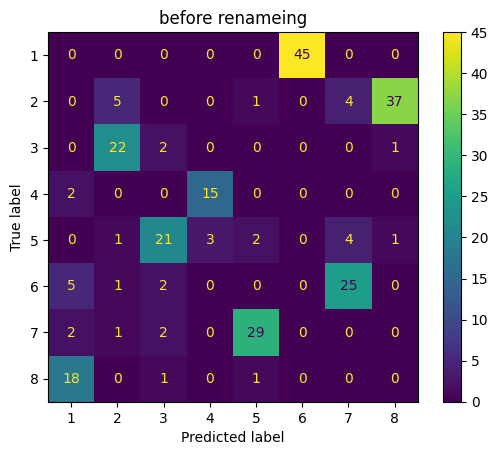

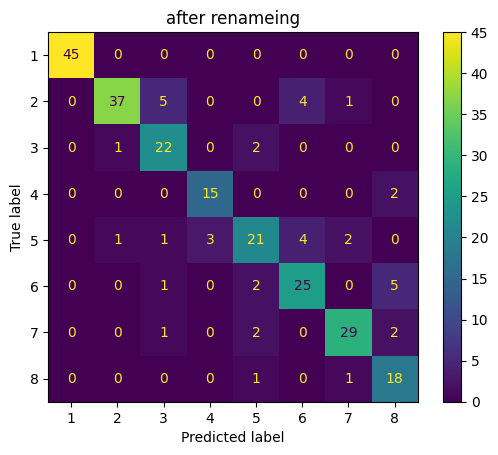

In [253]:
sample_level = True

if sample_level:
    # nmf_path = "/home/labs/amit/annaku/repos/MM_2024_AK/Shuang_scripts/outputs/arch_sample_v5_without_drivers.csv"
    nmf_path = "/home/labs/amit/annaku/repos/MM_2024_AK/Shuang_scripts/outputs/arch_sample_v5_with_drivers.csv"
else:
    nmf_path = "/home/labs/amit/annaku/repos/MM_2024_AK/Shuang_scripts/outputs/arch_sample_v4_without_drivers.csv"

# load old shuang architypes to rename our new ones
path_sh = '/home/labs/amit/shuangyi/Project_MM3/Atlas/scvi_diff/z_v4_cl_clus.Rds'
result = pyreadr.read_r(path_sh)
df_sh = result[None]
df_sh['PID'] = df_sh['PID'].str.lower()

if not sample_level:
    arch_score_df = pd.read_csv(nmf_path)
    arch_score_df['index'] = arch_score_df['index'].str.lower()
    arch_score_df = arch_score_df.set_index('index').drop(columns=['Unnamed: 0', 'Row.names'])
    
    print("make sure that the following manual cluster map match the print")
    print(pd.concat([arch_score_df['Cluster'], df_sh.set_index("PID")['clus_new']], axis=1).value_counts().sort_index())
    arch_map = {'1': '2', '2': '8', '3': '7', '4':'6', '5':'5', '6':'1', '7':'4', '8':'3'}
    
    arch_score_df = arch_score_df.rename(columns=arch_map)
    arch_score_df = arch_score_df.drop(columns='Cluster')
    arch_score_df = arch_score_df.merge(df_sh[["PID", "clus_new"]], how='inner', left_index=True, right_on='PID')
    arch_score_df = arch_score_df.set_index('PID')
    arch_score_df = arch_score_df.rename(columns={'clus_new': 'architype'})
    arch_score_df['architype'] = arch_score_df['architype'].astype(str)
else:
    arch_score_df = arch_score_df = pd.read_csv(nmf_path)
    arch_score_df['index'] = arch_score_df['index'].str.lower()
    arch_score_df['SID'] = arch_score_df['index']
    arch_score_df = arch_score_df.set_index('SID').drop(columns=['Unnamed: 0', 'Row.names', 'index'])
    arch_score_df = arch_score_df.rename(columns={'Cluster': 'architype'})

    print("make sure that the following manual cluster map match the print")
    arch_score_df['PID'] = pd.Series([str(sid)[:-2] for sid in arch_score_df.index], index=arch_score_df.index)
    cm = confusion_matrix(arch_score_df.merge(df_sh, how='inner', on="PID")['clus_new'].astype(int),
                      arch_score_df.merge(df_sh, how='inner', on="PID")['architype'].astype(int))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[int(i) for i in range(1,9)])
    disp.plot()
    disp.ax_.set_title('before renameing')
    
    # arch_map = {'1': '4', '2': '2', '3': '3', '4': '5', '5': '6', '6': '8',  '7': '1', '8': '7'} # for version with no MM drivers
    arch_map = {'1': '8', '2': '3', '3': '5', '4': '4', '5': '7', '6': '1', '7': '6', '8': '2'}
    
    arch_score_df = arch_score_df.rename(columns=arch_map)
    arch_score_df['architype'] = arch_score_df['architype'].apply(lambda x: arch_map[str(x)])
    
    cm = confusion_matrix(arch_score_df.merge(df_sh, how='inner', on="PID")['clus_new'].astype(int),
                      arch_score_df.merge(df_sh, how='inner', on="PID")['architype'].astype(int))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[int(i) for i in range(1,9)])
    disp.plot()
    disp.ax_.set_title('after renameing')

In [254]:
from sklearn.cluster import AgglomerativeClustering
linkage = 'ward'
metric = 'euclidean'
clusters = AgglomerativeClustering(n_clusters=8, linkage=linkage, metric=metric).fit_predict(arch_score_df[[str(i) for i in range(2,9)]])
clusters = pd.Series(clusters, index=arch_score_df.index, name='clasters') +1
# clusters

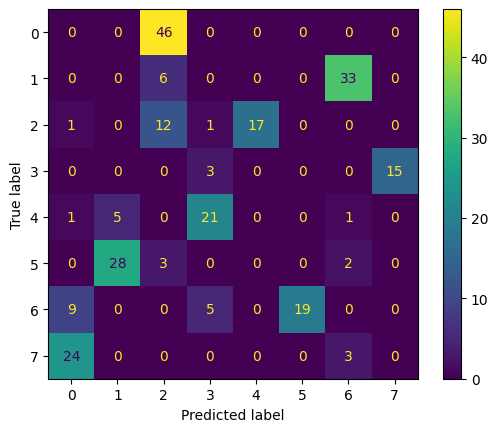

In [255]:
cm = confusion_matrix(y_true=arch_score_df['architype'].astype(int), 
                      y_pred=clusters.astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              # display_labels=[i for i in range(2,9)]
                             )
disp.plot()

In [256]:
cluster_to_arch_map = {i+1: arch for i, arch in enumerate(np.argmax(cm, axis=0) + 1)}
clusters = clusters.astype(int).map(cluster_to_arch_map)

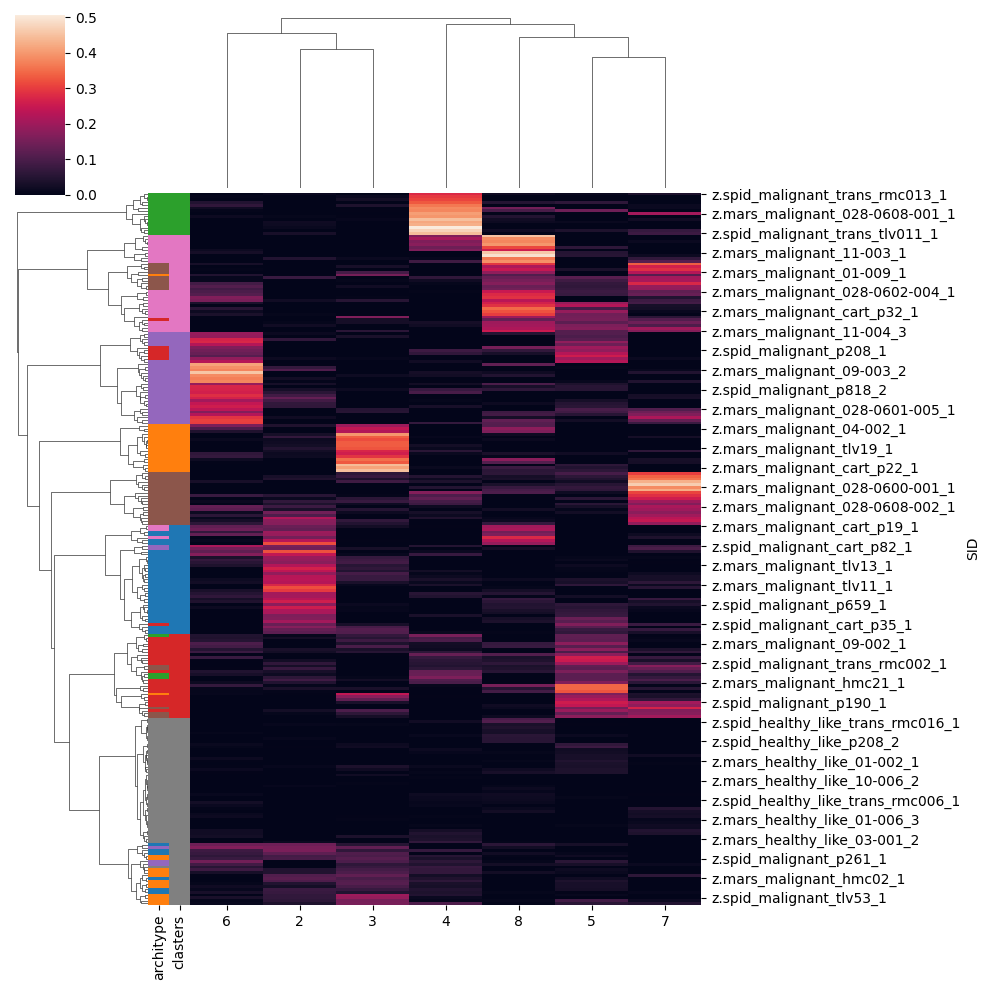

In [257]:
import seaborn as sns
arch_colors_map = {0: 'black', 1:'gray',  2:'tab:blue', 3:'tab:orange', 4:'tab:green', 5:'tab:red', 6:'tab:purple', 7:'tab:brown', 8:'tab:pink'}

colors_df = pd.concat([arch_score_df['architype'].astype(int).map(arch_colors_map),
                       clusters.astype(int).map(arch_colors_map)], axis=1)
sns.clustermap(arch_score_df[[str(i) for i in range(2,9)]], method=linkage, row_colors=colors_df, metric=metric)

In [258]:
h_cluster_col = 'h_clusters'
arch_score_df[h_cluster_col] = clusters

0.0168585883742019

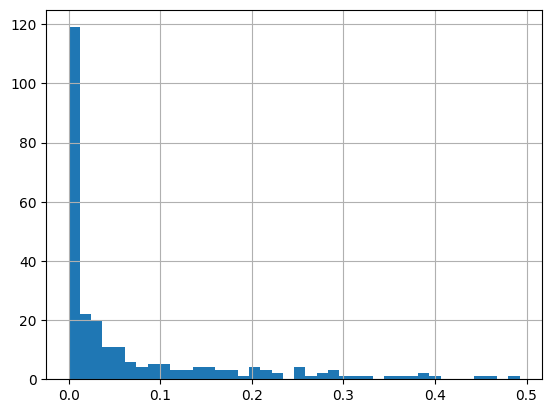

In [259]:
arch_score_df['8'].hist(bins=40)
arch_score_df['8'].median()
# (arch_score_df[arch_score_df['8'] > 0.1][h_cluster_col]).value_counts()

### patients dataframe

In [260]:
new_hospital_path = Path('/home/labs/amit/noamsh/data/mm_2023/clinical_prediction/Anonymized_CRF_BP_01082024.xlsx')
clinical_data = load_and_process_clinical_data(new_hospital_path, 
                                               code_lower_case=True, get_treatment_history=True, get_pfs_data=True,
                                               get_hospital_stage=False, get_post_treatment=True, get_combination_exposure=True,
                                               get_fish_data=True,
                                               additional_cols=['source_project', 'Original Code', 'Patient Code'])
clinical_data

Code  Biopsy sequence No.  Bortezomib  Ixazomib  Carfilzomib  \
0     tlv03                    1         NaN       NaN          NaN   
1     tlv07                    1         NaN       NaN          NaN   
2     tlv08                    1         NaN       NaN          NaN   
3     tlv09                    1         NaN       NaN          NaN   
4     tlv10                    1         NaN       NaN          NaN   
..      ...                  ...         ...       ...          ...   
262  tlv104                    1         NaN       NaN          NaN   
263  tlv106                    1         NaN       NaN          NaN   
264  tlv103                    1         NaN       NaN          NaN   
265  tlv105                    1         NaN       NaN          NaN   
266  tlv102                    2         2.0       NaN          2.0   

     Lenalidomide  Thalidomide  Pomalidomide  Cyclophosphamide  Chemotherapy  \
0             NaN          NaN           NaN               NaN           NaN   
1             NaN          NaN           NaN               NaN           NaN   
2             NaN          NaN           NaN               NaN           NaN   
3             NaN          NaN           NaN               NaN           NaN   
4             NaN          NaN           NaN               NaN           NaN   
..            ...          ...           ...               ...           ...   
262           NaN          NaN           NaN               NaN           NaN   
263           NaN          NaN           NaN               NaN           NaN   
264           NaN          NaN           NaN               NaN           NaN   
265           NaN          NaN           NaN               NaN           NaN   
266           2.0          NaN           NaN               1.0           2.0   

     ...  del(13q)  del(17p)  t(11:14)  t(4:14)  t(14:16)  t(14:20)  \
0    ...       NaN       NaN       NaN      NaN       NaN       NaN   
1    ...       NaN       NaN       NaN      NaN       NaN       NaN   
2    ...       0.0       0.0       0.0      0.0       0.0       0.0   
3    ...       NaN       NaN       NaN      NaN       NaN       NaN   
4    ...       0.0       0.0       0.0      0.0       0.0       0.0   
..   ...       ...       ...       ...      ...       ...       ...   
262  ...       0.0       0.0       0.0      0.0       0.0       0.0   
263  ...       NaN       NaN       NaN      NaN       NaN       NaN   
264  ...       0.0       0.0       0.0      0.0       0.0       0.0   
265  ...       NaN       NaN       NaN      NaN       NaN       NaN   
266  ...       NaN       NaN       NaN      NaN       NaN       NaN   

     IGH rearrangement  source_project  Original Code  Patient Code  
0                  NaN             TLV          TLV03        BP_001  
1                  NaN             TLV          TLV07        BP_002  
2                  0.0             TLV          TLV08        BP_003  
3                  NaN             TLV          TLV09        BP_004  
4                  0.0             TLV          TLV10        BP_005  
..                 ...             ...            ...           ...  
262                0.0             TLV         TLV104        BP_246  
263                NaN             TLV         TLV106        BP_247  
264                0.0             TLV         TLV103        BP_248  
265                NaN             TLV         TLV105        BP_249  
266                NaN             TLV         TLV102        BP_250  

[267 rows x 65 columns]

In [261]:
adata = ad.read_h5ad(Path(conf.outputs.output_dir, "adata_with_scvi_annot_pred_data_v_20240813_ts_2024-08-18_only_pc_annotated_filtered.h5ad"))
adata.obs['Hospital.Code'] = adata.obs['Hospital.Code'].apply(lambda h_code: f"cart_p{h_code.replace('cart','')}" if h_code in ('cart13', 'cart21') else h_code)

patients_df = extract_samples_metadata(adata, ['Disease', 'Project', 'Cohort'], 
                                       split_by_method=True, split_by_sample=True,
                                       generate_architype_id=True, generate_hl_architype_id=True, generate_sample_level_ids=sample_level,
                                       code_lower_case=True)
patients_df

Hospital.Code Method  Biopsy.Sequence         Disease          Project  \
0          01-001   MARS                1            RRMM            Kydar   
1          01-001   MARS                2            RRMM            Kydar   
2          01-001   MARS                3            RRMM            Kydar   
3          01-002   MARS                1            RRMM            Kydar   
4          01-002   MARS                2            RRMM            Kydar   
..            ...    ...              ...             ...              ...   
410  trans_tlv010   SPID                1  non_naive_NDMM  Transplantation   
411  trans_tlv011   SPID                1  non_naive_NDMM  Transplantation   
412  trans_tlv012   SPID                1  non_naive_NDMM  Transplantation   
413  trans_tlv013   SPID                1  non_naive_NDMM  Transplantation   
414  trans_tlv014   SPID                1  non_naive_NDMM  Transplantation   

              Cohort                            PID  \
0               RRMM        z.mars_malignant_01-001   
1               RRMM        z.mars_malignant_01-001   
2               RRMM        z.mars_malignant_01-001   
3               RRMM        z.mars_malignant_01-002   
4               RRMM        z.mars_malignant_01-002   
..               ...                            ...   
410  Transplantation  z.spid_malignant_trans_tlv010   
411  Transplantation  z.spid_malignant_trans_tlv011   
412  Transplantation  z.spid_malignant_trans_tlv012   
413  Transplantation  z.spid_malignant_trans_tlv013   
414  Transplantation  z.spid_malignant_trans_tlv014   

                                 SID                  PID_Healthy_Like  \
0          z.mars_malignant_01-001_1        z.mars_healthy_like_01-001   
1          z.mars_malignant_01-001_2        z.mars_healthy_like_01-001   
2          z.mars_malignant_01-001_3        z.mars_healthy_like_01-001   
3          z.mars_malignant_01-002_1        z.mars_healthy_like_01-002   
4          z.mars_malignant_01-002_2        z.mars_healthy_like_01-002   
..                               ...                               ...   
410  z.spid_malignant_trans_tlv010_1  z.spid_healthy_like_trans_tlv010   
411  z.spid_malignant_trans_tlv011_1  z.spid_healthy_like_trans_tlv011   
412  z.spid_malignant_trans_tlv012_1  z.spid_healthy_like_trans_tlv012   
413  z.spid_malignant_trans_tlv013_1  z.spid_healthy_like_trans_tlv013   
414  z.spid_malignant_trans_tlv014_1  z.spid_healthy_like_trans_tlv014   

                       SID_Healthy_Like  
0          z.mars_healthy_like_01-001_1  
1          z.mars_healthy_like_01-001_2  
2          z.mars_healthy_like_01-001_3  
3          z.mars_healthy_like_01-002_1  
4          z.mars_healthy_like_01-002_2  
..                                  ...  
410  z.spid_healthy_like_trans_tlv010_1  
411  z.spid_healthy_like_trans_tlv011_1  
412  z.spid_healthy_like_trans_tlv012_1  
413  z.spid_healthy_like_trans_tlv013_1  
414  z.spid_healthy_like_trans_tlv014_1  

[415 rows x 10 columns]

In [262]:
# in hospital not in our plates
# total_patients_merge = patients_df.merge(clinical_data, how='outer', left_on=['Hospital.Code', 'Biopsy.Sequence'],
#                                        right_on=['Code', 'Biopsy sequence No.'], indicator=True)

# total_patients_merge[total_patients_merge['_merge']=='right_only'][['Code', 'Biopsy sequence No.', 'source_project', 'Original Code', 'Patient Code']]

In [263]:
# with clinical data
patients_df = patients_df.merge(clinical_data, how='inner', left_on=['Hospital.Code', 'Biopsy.Sequence'],
                                       right_on=['Code', 'Biopsy sequence No.'], validate='m:1')
patients_df.shape

(246, 75)

In [264]:
len(patients_df['Hospital.Code'].unique())

228

In [265]:
# noted for now no garentee what clnical data will be chosen for patient with more than 1 clinical data
if sample_level:
    patients_df = patients_df.drop_duplicates("SID")
else:
    patients_df = patients_df.drop_duplicates("PID")
patients_df.shape

(246, 75)

### merge - patients with architype and clinical data

In [266]:
patients_df.shape

(246, 75)

In [267]:
# # # merge_on = "SID" if sample_level else "PID"
# # # patient_df_hl_mal = patients_df.merge(arch_score_df.reset_index(), on=merge_on, how = 'left')
# # # patient_df_hl_mal = patient_df_hl_mal.merge(arch_score_df.reset_index()[[merge_on, architype_col]],
# # #                                                 left_on=f'{merge_on}_Healthy_Like',right_on=merge_on, how='left')
# # # patient_df_hl_mal = patient_df_hl_mal.rename(columns={f'{merge_on}_x':merge_on , f'{architype_col}_x':architype_col, f'{architype_col}_y':'architype_hl'})
# patient_df_hl_mal = patients_df.merge(arch_score_df.reset_index(), on='SID', how = 'left')
# patient_df_hl_mal = patient_df_hl_mal.merge(arch_score_df.reset_index()[['SID', architype_col]],
#                                                 left_on='SID_Healthy_Like',right_on="SID", how='left')
# patient_df_hl_mal = patient_df_hl_mal.rename(columns={'SID_x':'SID', f'{architype_col}_x':architype_col, f'{architype_col}_y':'architype_hl'})
# patient_df_hl_mal.shape
# (patient_df_hl_mal[architype_col].isna() & patient_df_hl_mal['architype_hl'].isna()).value_counts()


In [268]:
architype_col = 'architype'

if not sample_level:
    patient_df_hl_mal = patients_df.merge(arch_score_df.reset_index(), on='PID', how = 'left')
    patient_df_hl_mal = patient_df_hl_mal.merge(arch_score_df.reset_index()[['PID', architype_col]],
                                                left_on='PID_Healthy_Like',right_on="PID", how='left')
    patient_df_hl_mal = patient_df_hl_mal.rename(columns={'PID_x':'PID', f'{architype_col}_x':architype_col, f'{architype_col}_y':'architype_hl'})
    patient_df_hl_mal = patient_df_hl_mal[~(patient_df_hl_mal[architype_col].isna() & patient_df_hl_mal['architype_hl'].isna())]
else:
    patient_df_hl_mal = patients_df.merge(arch_score_df.reset_index(), on='SID', how = 'left')
    patient_df_hl_mal = patient_df_hl_mal.merge(arch_score_df.reset_index()[['SID', architype_col]],
                                                left_on='SID_Healthy_Like',right_on="SID", how='left')
    patient_df_hl_mal = patient_df_hl_mal.rename(columns={'SID_x':'SID',
                                                          f'{architype_col}_x':architype_col,
                                                          f'{architype_col}_y':'architype_hl'})
    patient_df_hl_mal = patient_df_hl_mal[~(patient_df_hl_mal[architype_col].isna() & patient_df_hl_mal['architype_hl'].isna())]
    
patient_df_hl_mal[architype_col] = patient_df_hl_mal[architype_col].astype('category')
patient_df_hl_mal['architype_hl'] = patient_df_hl_mal['architype_hl'].astype('category')
patient_df_hl_mal


Hospital.Code Method  Biopsy.Sequence         Disease          Project  \
0          01-001   MARS                1            RRMM            Kydar   
1          01-001   MARS                3            RRMM            Kydar   
2          01-002   MARS                1            RRMM            Kydar   
3          01-003   MARS                2            RRMM            Kydar   
4          01-004   MARS                1            RRMM            Kydar   
..            ...    ...              ...             ...              ...   
238  trans_tlv003   SPID                1            RRMM  Transplantation   
239  trans_tlv005   SPID                1  non_naive_NDMM  Transplantation   
242  trans_tlv010   SPID                1  non_naive_NDMM  Transplantation   
243  trans_tlv011   SPID                1  non_naive_NDMM  Transplantation   
245  trans_tlv013   SPID                1  non_naive_NDMM  Transplantation   

              Cohort                          PID_x  \
0               RRMM        z.mars_malignant_01-001   
1               RRMM        z.mars_malignant_01-001   
2               RRMM        z.mars_malignant_01-002   
3               RRMM        z.mars_malignant_01-003   
4               RRMM        z.mars_malignant_01-004   
..               ...                            ...   
238  Transplantation  z.spid_malignant_trans_tlv003   
239  Transplantation  z.spid_malignant_trans_tlv005   
242  Transplantation  z.spid_malignant_trans_tlv010   
243  Transplantation  z.spid_malignant_trans_tlv011   
245  Transplantation  z.spid_malignant_trans_tlv013   

                                 SID                  PID_Healthy_Like  \
0          z.mars_malignant_01-001_1        z.mars_healthy_like_01-001   
1          z.mars_malignant_01-001_3        z.mars_healthy_like_01-001   
2          z.mars_malignant_01-002_1        z.mars_healthy_like_01-002   
3          z.mars_malignant_01-003_2        z.mars_healthy_like_01-003   
4          z.mars_malignant_01-004_1        z.mars_healthy_like_01-004   
..                               ...                               ...   
238  z.spid_malignant_trans_tlv003_1  z.spid_healthy_like_trans_tlv003   
239  z.spid_malignant_trans_tlv005_1  z.spid_healthy_like_trans_tlv005   
242  z.spid_malignant_trans_tlv010_1  z.spid_healthy_like_trans_tlv010   
243  z.spid_malignant_trans_tlv011_1  z.spid_healthy_like_trans_tlv011   
245  z.spid_malignant_trans_tlv013_1  z.spid_healthy_like_trans_tlv013   

                       SID_Healthy_Like  ...             4             7  \
0          z.mars_healthy_like_01-001_1  ...  2.220446e-16  1.087112e-01   
1          z.mars_healthy_like_01-001_3  ...  2.787658e-02  1.441867e-01   
2          z.mars_healthy_like_01-002_1  ...           NaN           NaN   
3          z.mars_healthy_like_01-003_2  ...           NaN           NaN   
4          z.mars_healthy_like_01-004_1  ...  9.201130e-03  6.542747e-02   
..                                  ...  ...           ...           ...   
238  z.spid_healthy_like_trans_tlv003_1  ...  2.220446e-16  3.777625e-02   
239  z.spid_healthy_like_trans_tlv005_1  ...  2.220446e-16  2.220446e-16   
242  z.spid_healthy_like_trans_tlv010_1  ...           NaN           NaN   
243  z.spid_healthy_like_trans_tlv011_1  ...  4.458906e-01  8.083823e-02   
245  z.spid_healthy_like_trans_tlv013_1  ...           NaN           NaN   

                1             6             2  architype  \
0    3.153320e-08  2.220446e-16  2.220446e-16          5   
1    3.070589e-02  1.113893e-07  6.901870e-03          8   
2             NaN           NaN           NaN        NaN   
3             NaN           NaN           NaN        NaN   
4    2.220446e-16  2.220446e-16  4.671581e-02          8   
..            ...           ...           ...        ...   
238  2.921962e-08  9.209676e-03  2.130748e-03          3   
239  2.220446e-16  1.885554e-01  1.349306e-14          6   
242           NaN           NaN           NaN        NaN   
243 

In [269]:
# samples or patients with mutiple samples
patient_df_hl_mal["Hospital.Code"].value_counts()[patient_df_hl_mal["Hospital.Code"].value_counts() > 1]

Hospital.Code
01-005       2
csa-01-03    2
10-004       2
cart_p36     2
cart_p21     2
11-004       2
cart_p24     2
01-001       2
01-009       2
01-008       2
tlv53        2
Name: count, dtype: int64

### both malignant and healthylike

In [270]:
def _get_pc_representation(patient_row):
    has_mal_arch = patient_row[architype_col] == patient_row[architype_col]
    has_hl_arch = patient_row['architype_hl'] == patient_row['architype_hl']
    if has_hl_arch and has_mal_arch:
        return 'both'
    if has_hl_arch:
        return "only healthy like"
    if has_mal_arch:
        return "only malignant"
    return "no representation"

pc_representation_col = 'pc_representation_col'
patient_df_hl_mal[pc_representation_col] = patient_df_hl_mal.apply(_get_pc_representation, axis=1)
patient_df_hl_mal[pc_representation_col].value_counts()

pc_representation_col
only malignant       141
only healthy like     15
both                   4
Name: count, dtype: int64

### statistical enrichment

In [271]:
from clinical_predictions.clinical_data_loading import add_response_columns_to_drug_combination, add_response_columns_to_specific_treatment

In [272]:
pateints_df_to_show = patient_df_hl_mal[patient_df_hl_mal["Biopsy.Sequence"] == 1]
pateints_df_to_show['has_high_8'] = pateints_df_to_show['8'] > 0.1
pateints_df_to_show[h_cluster_col] = pateints_df_to_show[h_cluster_col].astype('category')
pateints_df_to_show

/tmp/ipykernel_1694856/989219150.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1694856/989219150.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Hospital.Code Method  Biopsy.Sequence         Disease          Project  \
0          01-001   MARS                1            RRMM            Kydar   
2          01-002   MARS                1            RRMM            Kydar   
4          01-004   MARS                1            RRMM            Kydar   
5          01-005   MARS                1            RRMM            Kydar   
7          01-006   MARS                1            RRMM            Kydar   
..            ...    ...              ...             ...              ...   
238  trans_tlv003   SPID                1            RRMM  Transplantation   
239  trans_tlv005   SPID                1  non_naive_NDMM  Transplantation   
242  trans_tlv010   SPID                1  non_naive_NDMM  Transplantation   
243  trans_tlv011   SPID                1  non_naive_NDMM  Transplantation   
245  trans_tlv013   SPID                1  non_naive_NDMM  Transplantation   

              Cohort                          PID_x  \
0               RRMM        z.mars_malignant_01-001   
2               RRMM        z.mars_malignant_01-002   
4               RRMM        z.mars_malignant_01-004   
5               RRMM        z.mars_malignant_01-005   
7               RRMM        z.mars_malignant_01-006   
..               ...                            ...   
238  Transplantation  z.spid_malignant_trans_tlv003   
239  Transplantation  z.spid_malignant_trans_tlv005   
242  Transplantation  z.spid_malignant_trans_tlv010   
243  Transplantation  z.spid_malignant_trans_tlv011   
245  Transplantation  z.spid_malignant_trans_tlv013   

                                 SID                  PID_Healthy_Like  \
0          z.mars_malignant_01-001_1        z.mars_healthy_like_01-001   
2          z.mars_malignant_01-002_1        z.mars_healthy_like_01-002   
4          z.mars_malignant_01-004_1        z.mars_healthy_like_01-004   
5          z.mars_malignant_01-005_1        z.mars_healthy_like_01-005   
7          z.mars_malignant_01-006_1        z.mars_healthy_like_01-006   
..                               ...                               ...   
238  z.spid_malignant_trans_tlv003_1  z.spid_healthy_like_trans_tlv003   
239  z.spid_malignant_trans_tlv005_1  z.spid_healthy_like_trans_tlv005   
242  z.spid_malignant_trans_tlv010_1  z.spid_healthy_like_trans_tlv010   
243  z.spid_malignant_trans_tlv011_1  z.spid_healthy_like_trans_tlv011   
245  z.spid_malignant_trans_tlv013_1  z.spid_healthy_like_trans_tlv013   

                       SID_Healthy_Like  ...             1             6  \
0          z.mars_healthy_like_01-001_1  ...  3.153320e-08  2.220446e-16   
2          z.mars_healthy_like_01-002_1  ...           NaN           NaN   
4          z.mars_healthy_like_01-004_1  ...  2.220446e-16  2.220446e-16   
5          z.mars_healthy_like_01-005_1  ...  2.220446e-16  6.788309e-02   
7          z.mars_healthy_like_01-006_1  ...  2.220446e-16  1.629901e-01   
..                                  ...  ...           ...           ...   
238  z.spid_healthy_like_trans_tlv003_1  ...  2.921962e-08  9.209676e-03   
239  z.spid_healthy_like_trans_tlv005_1  ...  2.220446e-16  1.885554e-01   
242  z.spid_healthy_like_trans_tlv010_1  ...           NaN           NaN   
243  z.spid_healthy_like_trans_tlv011_1  ...  5.515799e-02  1.011263e-07   
245  z.spid_healthy_like_trans_tlv013_1  ...           NaN           NaN   

                2  architype                          PID_y  h_clusters  \
0    2.220446e-16          5        z.mars_malignant_01-001         8.0   
2             NaN        NaN                            NaN         NaN   
4    4.671581e-02          8        z.mars_malignant_01-004         8.0   
5    1.967028e-01          2        z.mars_malignant_01-005         2.0   
7    2.220446e-16          5        z.mars_malignant_01-006         6.0   
..            ...        ...                            ...         ...   
238  2.130748e-03          3  z.spid_malignant_trans_tlv003         5.0   
239 

In [341]:
enrichment_col = h_cluster_col # architype_col 

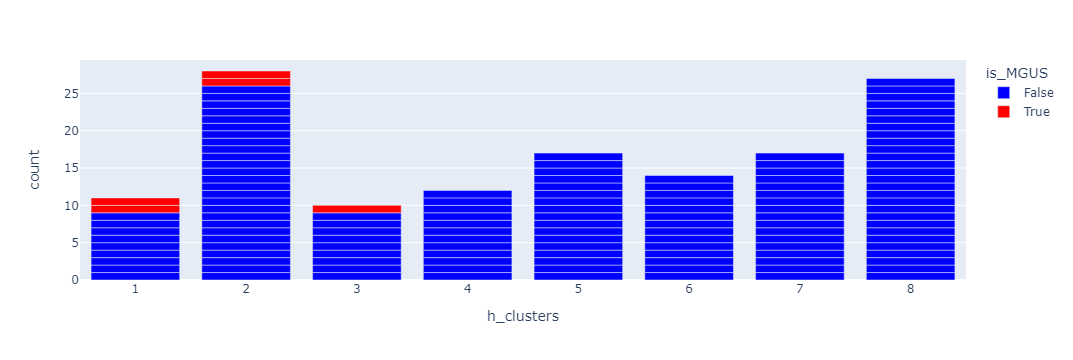

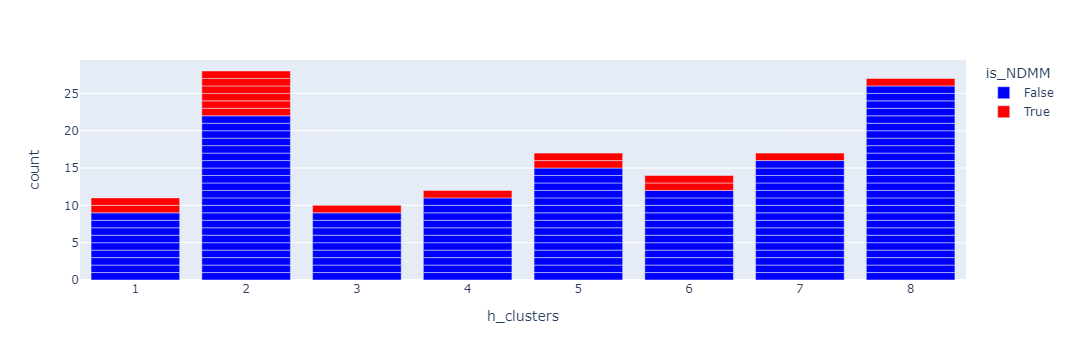

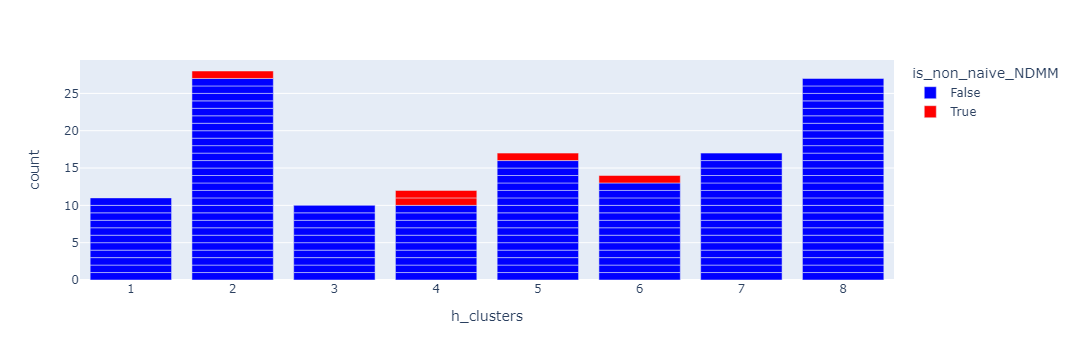

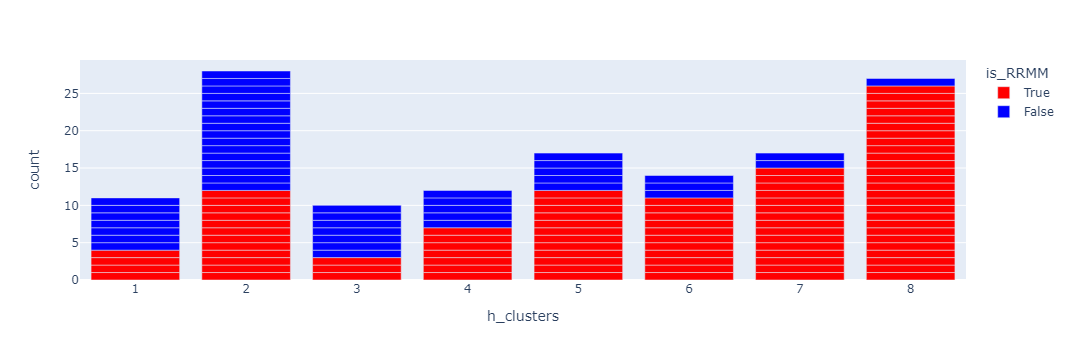

In [342]:
for disease in ["MGUS", "NDMM" , "non_naive_NDMM", "RRMM"]:
    pateints_df_to_show[f"is_{disease}"] = pateints_df_to_show["Disease"] == disease
    f = px.bar(pateints_df_to_show, x=enrichment_col, color=f"is_{disease}", hover_data=['Hospital.Code', '8'],
               color_discrete_map={True:'red', False:'blue'})
    f.update_xaxes(categoryorder='category ascending')   
    f.show()

In [343]:
patient_df_hl_mal[patient_df_hl_mal[pc_representation_col]!='only malignant']

Hospital.Code Method  Biopsy.Sequence         Disease          Project  \
2          01-002   MARS                1            RRMM            Kydar   
3          01-003   MARS                2            RRMM            Kydar   
11         01-008   MARS                3            RRMM            Kydar   
14         01-010   MARS                1            RRMM            Kydar   
17         04-001   MARS                2            RRMM            Kydar   
23         04-006   MARS                2            RRMM            Kydar   
41         11-004   MARS                3            RRMM            Kydar   
139         hmc04   MARS                1            MGUS            Pilot   
144         hmc09   MARS                1            MGUS            Pilot   
164         tlv20   MARS                1  non_naive_NDMM            Pilot   
203         tlv78   SPID                1            RRMM              TLV   
214         tlv95   SPID                1            MGUS             RRMM   
223  trans_rmc002   SPID                1  non_naive_NDMM  Transplantation   
224  trans_rmc003   SPID                1  non_naive_NDMM  Transplantation   
226  trans_rmc006   SPID                1  non_naive_NDMM  Transplantation   
234  trans_rmc016   SPID                1  non_naive_NDMM  Transplantation   
239  trans_tlv005   SPID                1  non_naive_NDMM  Transplantation   
242  trans_tlv010   SPID                1  non_naive_NDMM  Transplantation   
245  trans_tlv013   SPID                1  non_naive_NDMM  Transplantation   

              Cohort                          PID_x  \
2               RRMM        z.mars_malignant_01-002   
3               RRMM        z.mars_malignant_01-003   
11              RRMM        z.mars_malignant_01-008   
14              RRMM        z.mars_malignant_01-010   
17              RRMM        z.mars_malignant_04-001   
23              RRMM        z.mars_malignant_04-006   
41              RRMM        z.mars_malignant_11-004   
139             MGUS         z.mars_malignant_hmc04   
144             NDMM         z.mars_malignant_hmc09   
164   non_naive_NDMM         z.mars_malignant_tlv20   
203              TLV         z.spid_malignant_tlv78   
214             RRMM         z.spid_malignant_tlv95   
223  Transplantation  z.spid_malignant_trans_rmc002   
224  Transplantation  z.spid_malignant_trans_rmc003   
226  Transplantation  z.spid_malignant_trans_rmc006   
234  Transplantation  z.spid_malignant_trans_rmc016   
239  Transplantation  z.spid_malignant_trans_tlv005   
242  Transplantation  z.spid_malignant_trans_tlv010   
245  Transplantation  z.spid_malignant_trans_tlv013   

                                 SID                  PID_Healthy_Like  \
2          z.mars_malignant_01-002_1        z.mars_healthy_like_01-002   
3          z.mars_malignant_01-003_2        z.mars_healthy_like_01-003   
11         z.mars_malignant_01-008_3        z.mars_healthy_like_01-008   
14         z.mars_malignant_01-010_1        z.mars_healthy_like_01-010   
17         z.mars_malignant_04-001_2        z.mars_healthy_like_04-001   
23         z.mars_malignant_04-006_2        z.mars_healthy_like_04-006   
41         z.mars_malignant_11-004_3        z.mars_healthy_like_11-004   
139         z.mars_malignant_hmc04_1         z.mars_healthy_like_hmc04   
144         z.mars_malignant_hmc09_1         z.mars_healthy_like_hmc09   
164         z.mars_malignant_tlv20_1         z.mars_healthy_like_tlv20   
203         z.spid_malignant_tlv78_1         z.spid_healthy_like_tlv78   
214         z.spid_malignant_tlv95_1         z.spid_healthy_like_tlv95   
223  z.spid_malignant_trans_rmc002_1  z.spid_healthy_like_trans_rmc002   
224  z.spid_malignant_trans_rmc003_1  z.spid_healthy_like_trans_rmc003   
226  z.spid_malignant_trans_rmc006_1  z.spid_healthy_like_trans_rmc006   
234  z.spid_malignant_trans_rmc016_1  z.spid_healthy_like_trans_rmc016   
239  z.spid_malignant_trans_tlv005_1  z.spid_healthy_like_trans_tlv005   
242  z.spi

### response

#### generate response data

In [344]:
from clinical_predictions.clinical_data_loading import add_Kydar_response

combinations = ["Triple", "Penta", 'Kydar']
kydar_pfs_months = 9
for comb in combinations:
    # response_policy = 'exposed_non_refractory'
    response_policy = 'NDMM_SMM|exposed_non_refractory'
    no_response_policy = 'refractory'
    if comb == "Kydar":
        pateints_df_to_show = add_Kydar_response(pateints_df_to_show, kydar_pfs_months)
    else:
        pateints_df_to_show = add_response_columns_to_drug_combination(pateints_df_to_show, comb, response_policy=response_policy, no_response_policy=no_response_policy)

/home/labs/amit/noamsh/repos/MM_2023/clinical_predictions/clinical_data_loading.py:251: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/labs/amit/noamsh/repos/MM_2023/clinical_predictions/clinical_data_loading.py:252: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [345]:
CAR_T_full_clinical_data_path = Path('/home/labs/amit/noamsh/data/mm_2023/clinical_prediction/CART MM responder vs non responder 160424.xlsx')
CAR_T_full_clinical_data = load_dataframe_from_file(CAR_T_full_clinical_data_path)


In [346]:
from clinical_predictions.clinical_data_loading import add_CART_response

treatments = ["CART", "Lenalidomide", "Daratumumab"]
cart_pfs_policy = "9M PFS"

for treatment in treatments:
    # response_policy = 'post_sensitive'
    # no_response_policy = 'post_refractory'
    response_policy = 'NDMM_SMM|post_sensitive'
    no_response_policy = 'pre_refractory|post_refractory'
    
    if treatment == "CART":
        pateints_df_to_show = add_CART_response(pateints_df_to_show, CAR_T_full_clinical_data, pfs_policy=cart_pfs_policy)
    else:
        pateints_df_to_show = add_response_columns_to_specific_treatment(pateints_df_to_show, treatment,
                                                              response_policy=response_policy,
                                                              no_response_policy=no_response_policy,
                                                              raise_errors=False)

/home/labs/amit/noamsh/repos/MM_2023/clinical_predictions/clinical_data_loading.py:238: UserWarning:

some patients follow both response and no response policies for treatment: Lenalidomide
will consider them as non responders

    Cohort  Biopsy.Sequence Lenalidomide_response Method  Lenalidomide  \
102   NDMM                1                    NR   MARS           NaN   
117   RRMM                1                    NR   MARS           NaN   
118    TLV                1                    NR   SPID           NaN   
131   NDMM                1                    NR   SPID           NaN   

     Lenalidomide.2 Disease Hospital.Code Project  
102             2.0    NDMM         tlv22   Pilot  
117             2.0    NDMM         tlv53     TLV  
118             2.0    NDMM         tlv53     TLV  
131             2.0    NDMM         tlv94    NDMM   

/home/labs/amit/noamsh/repos/MM_2023/clinical_predictions/clinical_data_loading.py:238: UserWarning:

some patients follow both response an

In [347]:
from clinical_predictions.clinical_data_loading import add_general_response

pateints_df_to_show = add_general_response(pateints_df_to_show)

/home/labs/amit/noamsh/repos/MM_2023/clinical_predictions/clinical_data_loading.py:293: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/labs/amit/noamsh/repos/MM_2023/clinical_predictions/clinical_data_loading.py:310: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### plot response data

In [348]:
pateints_df_to_show.shape

(148, 102)

In [349]:
response_cols = [f"{treat}_response" for treat in combinations+treatments] +[general_response_col, general_pfs_response_col]
v_counts = []
for col in response_cols:
    v_counts.append(pateints_df_to_show[col].value_counts().rename(col))
pd.concat(v_counts, axis=1)

Triple_response  Penta_response  Kydar_response  CART_response  \
R                43              40              20             16   
NR               41               6              14             10   

    Lenalidomide_response  Daratumumab_response  general_response  \
R                      22                    22                91   
NR                     60                    61                26   

    general_pfs_response  
R                     60  
NR                    23

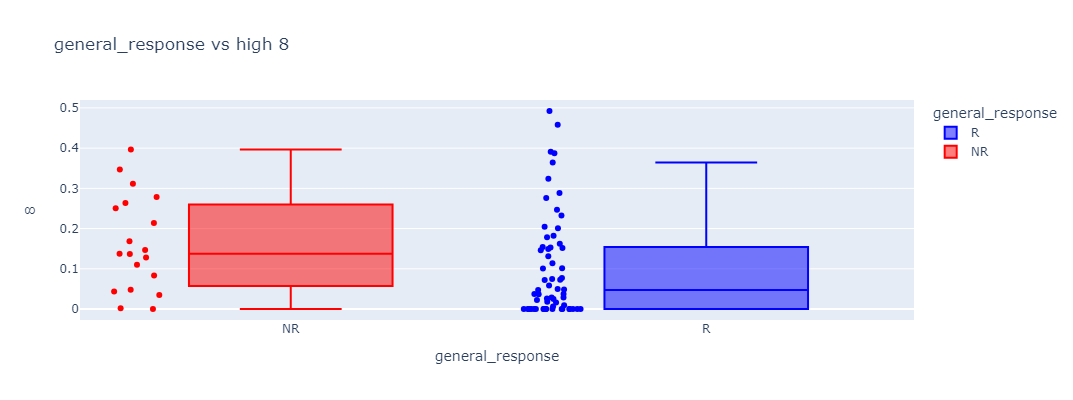

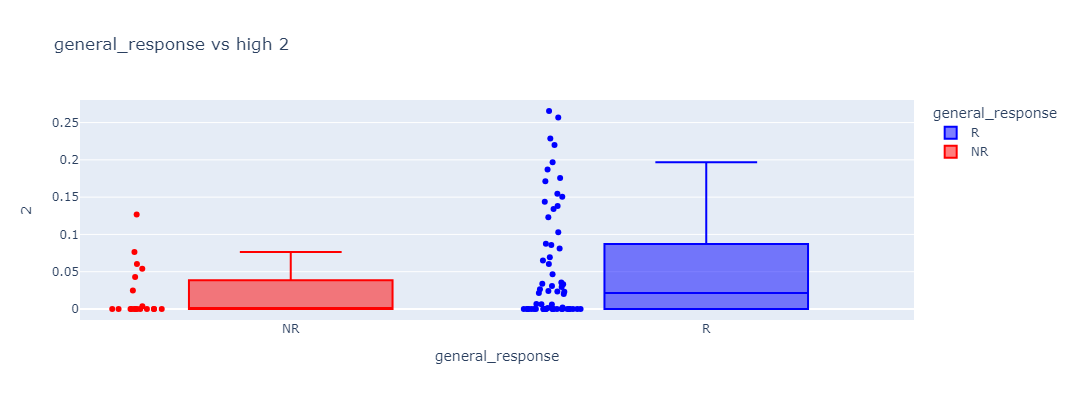

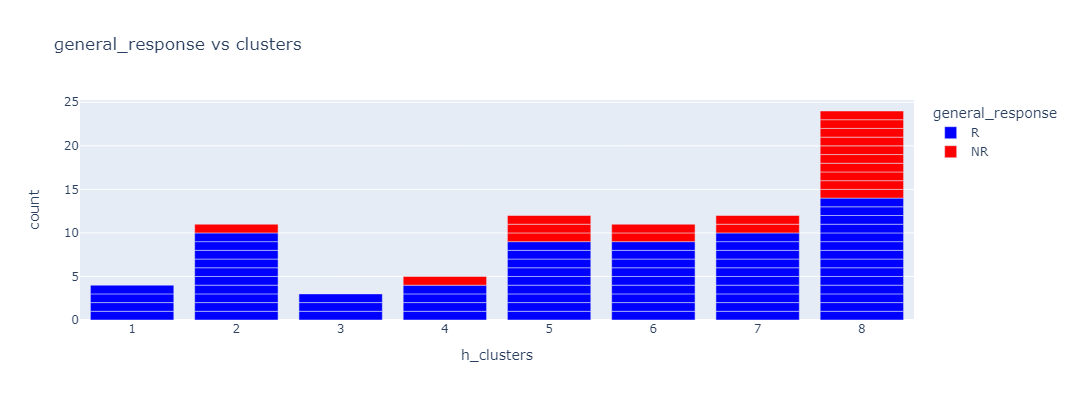

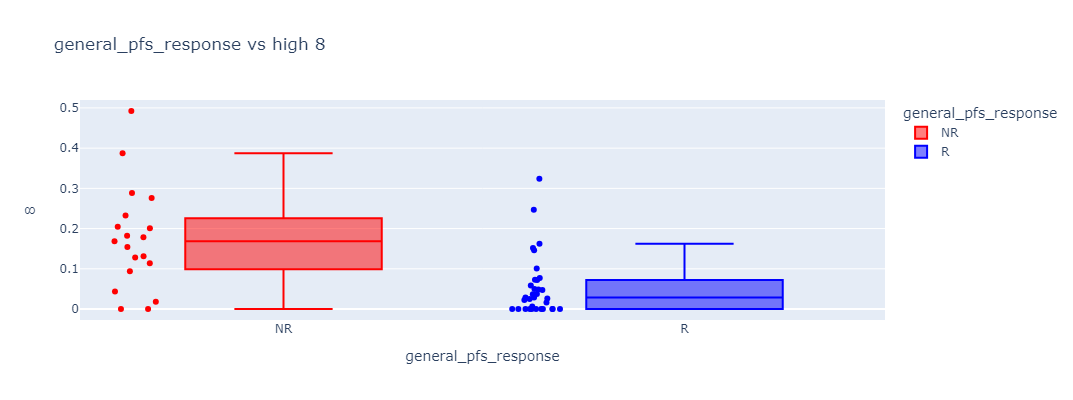

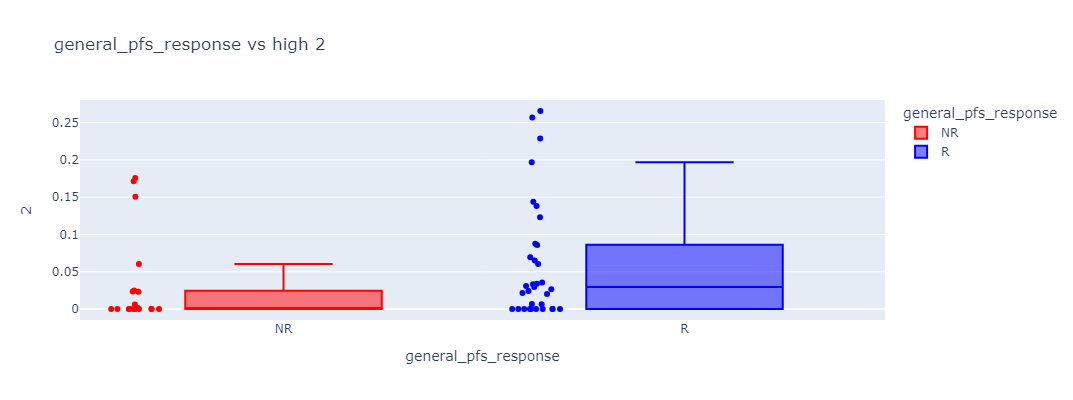

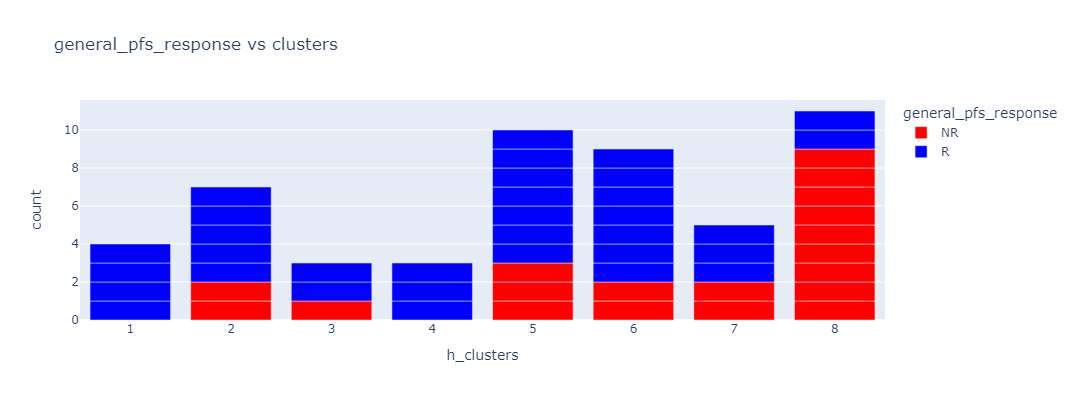

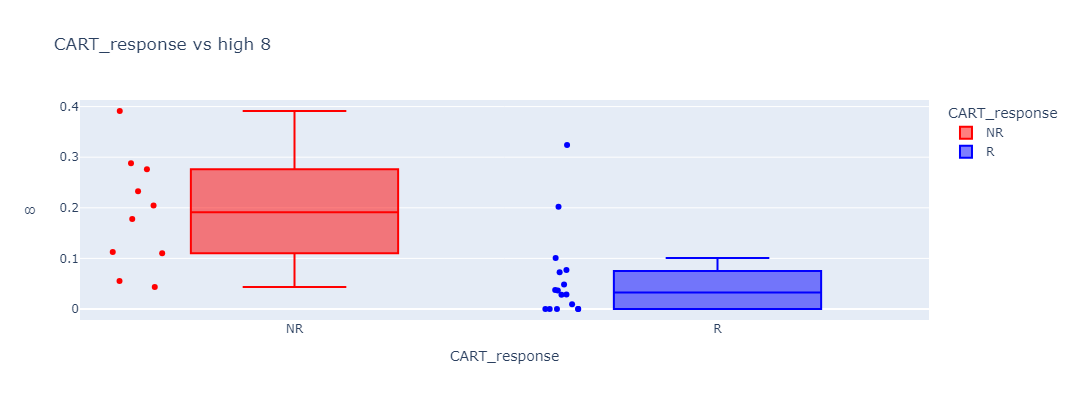

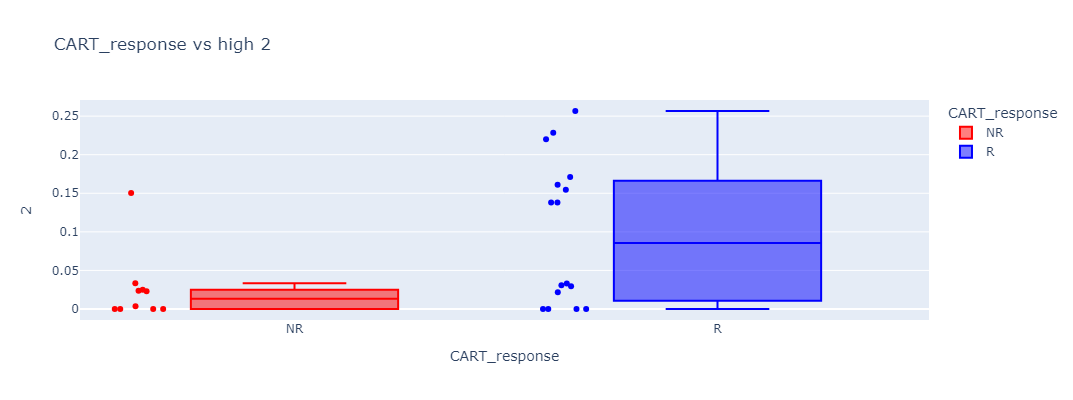

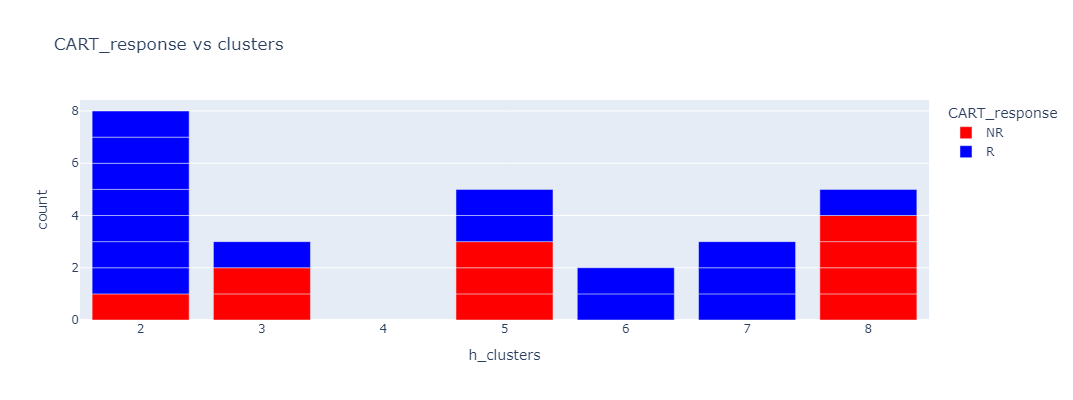

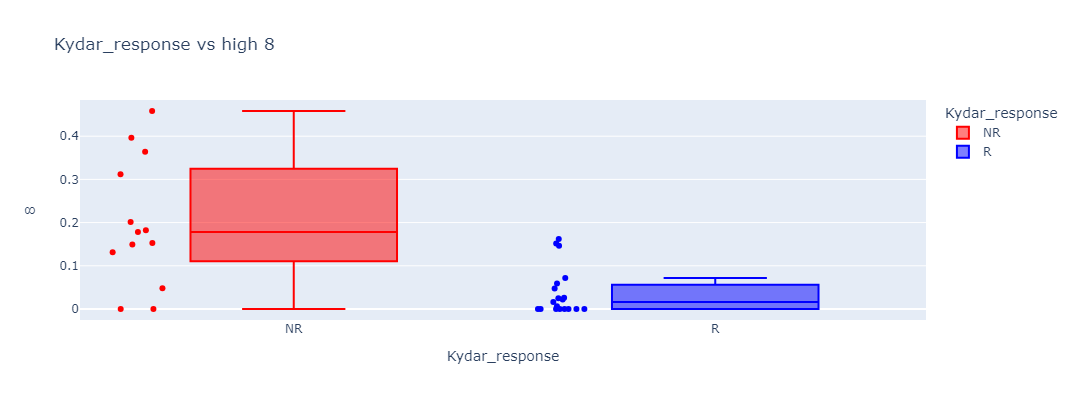

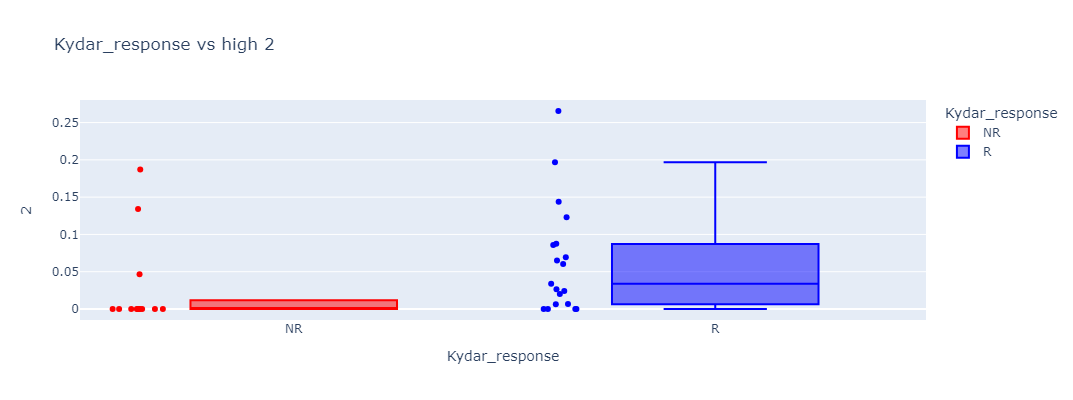

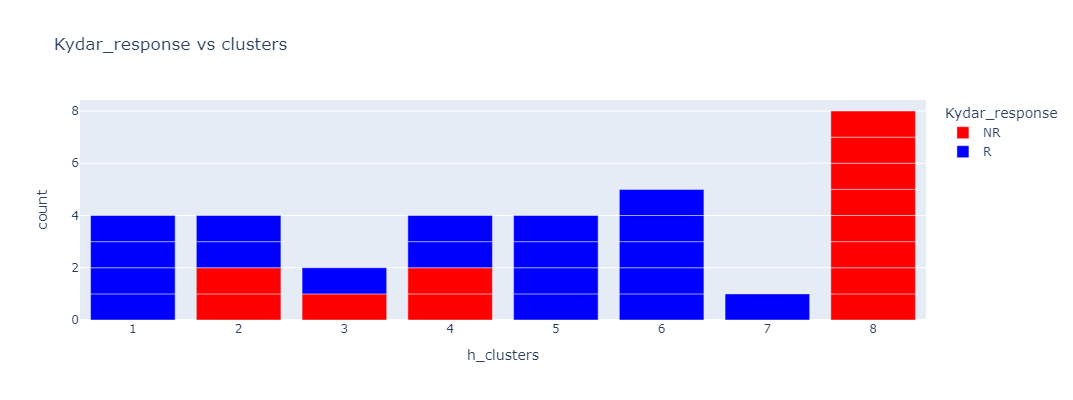

In [350]:
for treat in ['general', 'general_pfs', "CART", "Kydar"]:
    col = f"{treat}_response"
    if 'general' in treat:
        df = pateints_df_to_show[pateints_df_to_show['Disease']=="RRMM"]
    else:
        df = pateints_df_to_show[~pateints_df_to_show[col].isna()]
    fig = make_subplots(rows=1, cols=2) 

    for arch_col in ['8', '2']:
        f = px.box(df, title=f"{col} vs high {arch_col}",
           y=arch_col, # architype_col
           x=col, hover_data=["Hospital.Code", '2', '8', 'Disease'], points="all", color=col,
           color_discrete_map={'NR':'red', 'R':'blue'})
        # for trace in range(len(f["data"])):
        #     fig.add_trace(f["data"][trace], row=1, col=1)
        f.update_layout(autosize=False, width=500, height=400)
        f.update_xaxes(categoryorder='category ascending')
        f.show()
    f = px.bar(df, title=f"{col} vs clusters",
               x=enrichment_col,
               color=col, hover_data=["Hospital.Code", '8', 'Disease'],
               color_discrete_map={'NR':'red', 'R':'blue'})
    f.update_xaxes(categoryorder='category ascending')
    f.update_layout( autosize=False, width=600, height=400)
    f.show()
    # for trace in range(len(f["data"])):
    #     fig.add_trace(f["data"][trace], row=1, col=2)
    # fig.show()


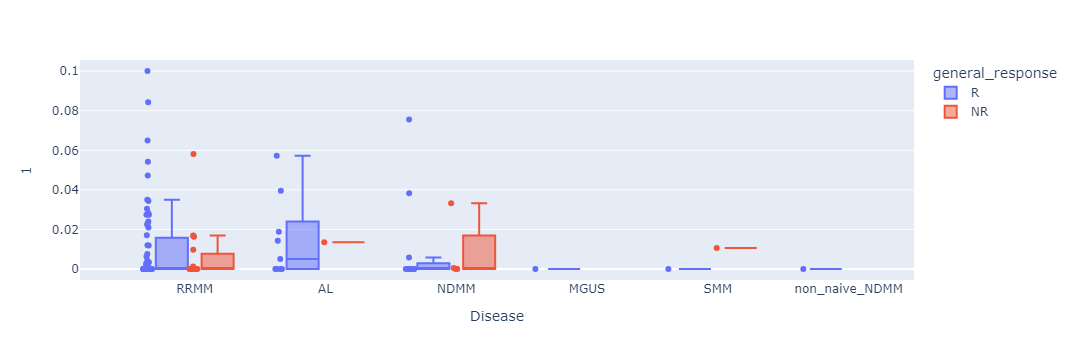

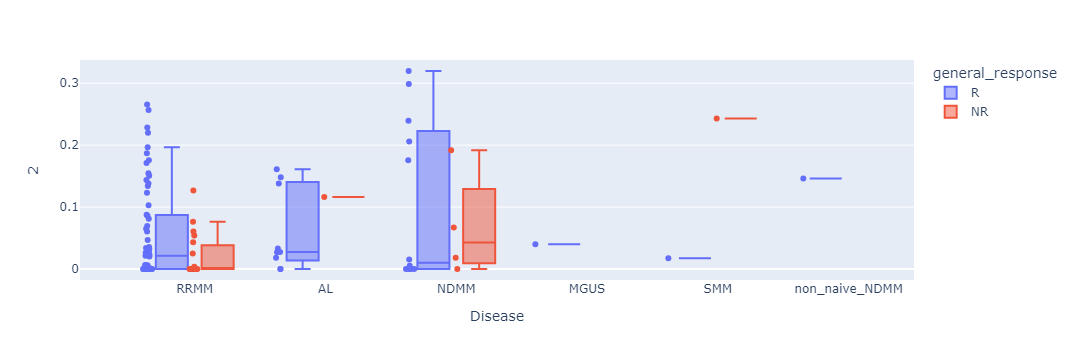

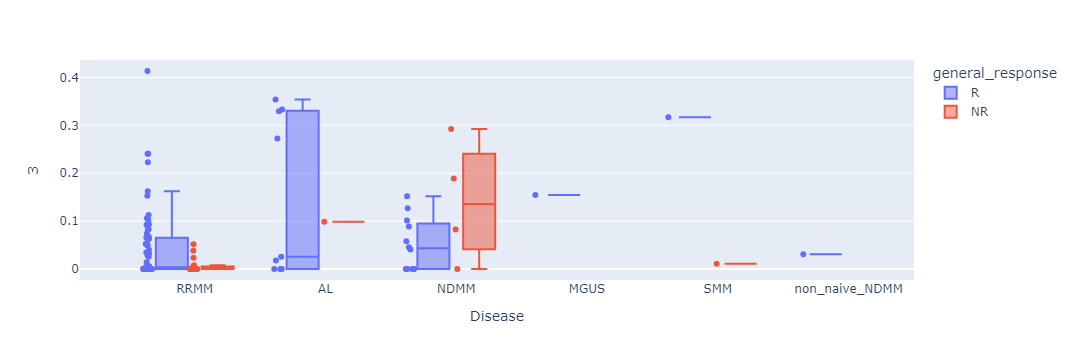

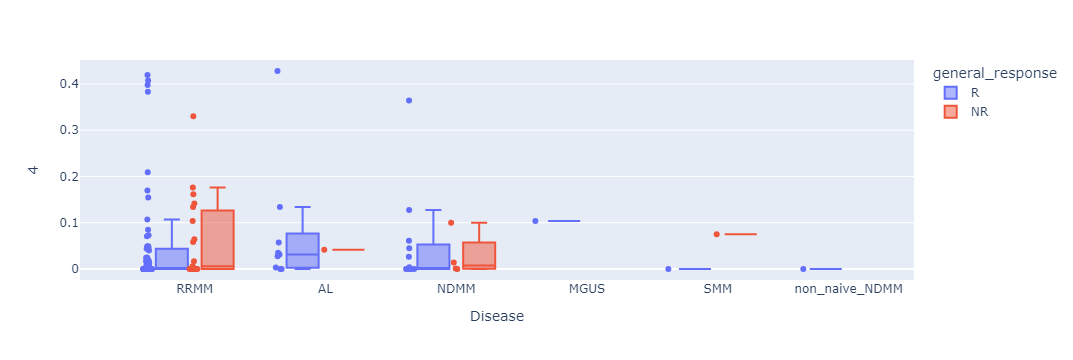

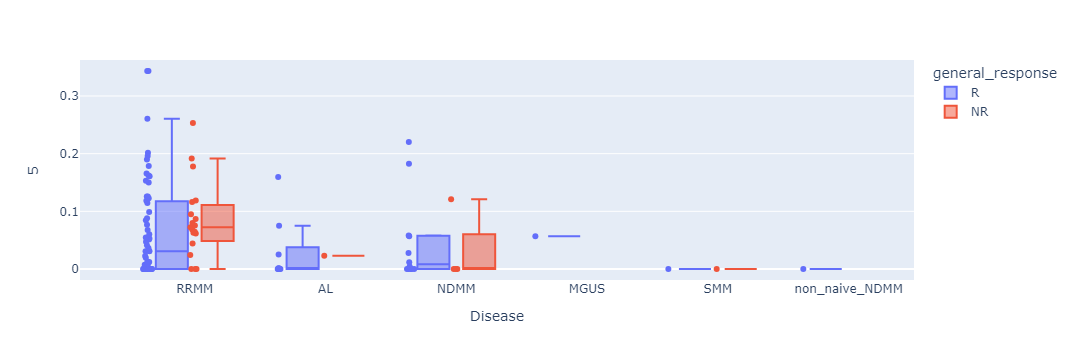

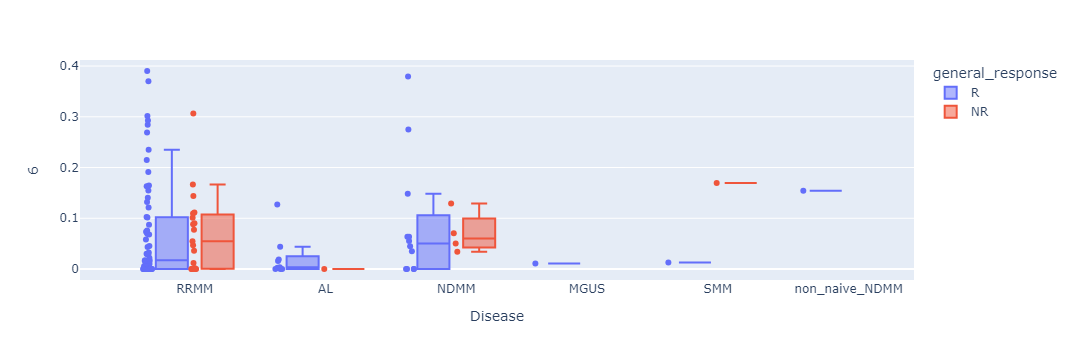

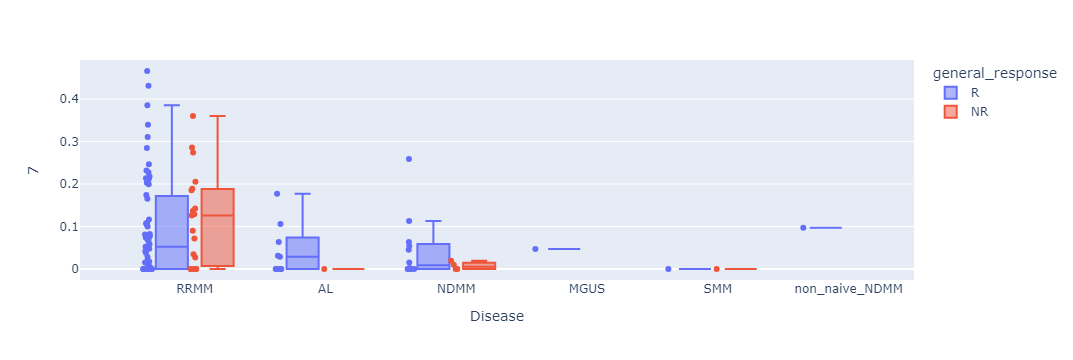

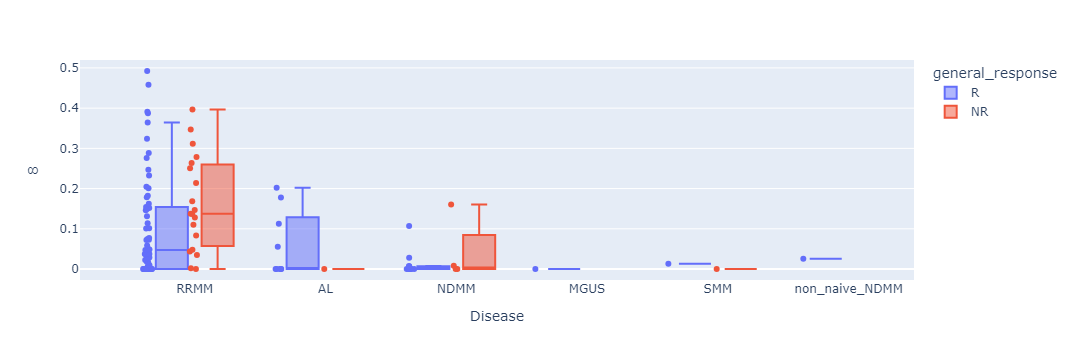

In [351]:
for arch in [str(i) for i in range(1,9)]:
    f = px.box(pateints_df_to_show,
               x='Disease', y=arch , color='general_response', 
               points="all", hover_data=['Hospital.Code'] 
               # title=f"{'proportion' if norm_counts else 'count'} of {cell_population_to_plot} in samples"
              )
    f.show()

### healthy like and response

In [352]:
for disease in ['RRMM', 'non_naive_NDMM', 'NDMM']:
    f = px.bar(pateints_df_to_show[pateints_df_to_show['Disease']==disease],
           title=f'{disease} general response (any senstivity - best response), exsistance of healthy like',
           x='general_response', color=pc_representation_col, hover_data=["Hospital.Code"],
           color_discrete_map={'only malignant':'red', 'only healthy like':'blue', 'both': 'green'})
    f.update_xaxes(categoryorder='category ascending')   
    f.show()
    

In [353]:
for treatment in ['Kydar', 'CART']:
    f = px.bar(pateints_df_to_show, x=f'{treatment}_response', color=pc_representation_col, hover_data=["Hospital.Code"],
               color_discrete_map={'only malignant':'red', 'only healthy like':'blue', 'both': 'green'})
    f.update_xaxes(categoryorder='category ascending')
    f.show()


In [354]:
f = px.bar(pateints_df_to_show[~pateints_df_to_show[architype_col].isna()],
           x=architype_col, color=pc_representation_col, hover_data=["Hospital.Code"],
           title='patients with healthylike by architypes',
           color_discrete_map={'only malignant':'red', 'only healthy like':'blue', 'both': 'green'})
f.update_xaxes(categoryorder='category ascending')   
f.show()

### pvals

In [355]:
from itertools import product
from scipy.stats import hypergeom
from collections import defaultdict
import pandas as pd

In [356]:
pateints_df_mal = pateints_df_to_show[~pateints_df_to_show[enrichment_col].isna()]
pateints_df_mal.shape

(136, 102)

In [357]:
proba_lower_or_equel_dict = defaultdict(list)
proba_higher_or_equel_dict = defaultdict(list)
params_dict = defaultdict(list)
architypes = pateints_df_to_show[enrichment_col].unique()
for treatment, architype in product(combinations+treatments+["general", 'general_pfs'] , architypes):
    treatment_col = f"{treatment}_response"
    M = sum(~pateints_df_to_show[treatment_col].isna())
    n = sum(pateints_df_to_show[treatment_col] == "R")
    
    architype_patients = pateints_df_to_show[pateints_df_to_show[enrichment_col] == architype]
    N = sum(~architype_patients[treatment_col].isna())
    x = sum(architype_patients[treatment_col] == "R")
    
    rv = hypergeom(M, n, N)
    prb_pdf = rv.pmf(x)
    prb_cdf = hypergeom.cdf(x, M, n, N)
    
    proba_lower_or_equel_dict[treatment].append(prb_cdf)
    proba_higher_or_equel_dict[treatment].append(1-prb_cdf+prb_pdf)
    params_dict[treatment].append((M, n, N, x))

proba_lower_or_equel_df = pd.DataFrame(dict(proba_lower_or_equel_dict), index=architypes)
proba_higher_or_equel_df = pd.DataFrame(dict(proba_higher_or_equel_dict), index=architypes)
params_df = pd.DataFrame(dict(params_dict), index=architypes)

In [358]:
# probability that the number of R in the archytype will be lower or equel assuming random sampling from all architypes
# if p_val is low there is under abandance of R

proba_lower_or_equel_df.sort_index()

Triple     Penta     Kydar      CART  Lenalidomide  Daratumumab  \
 1.0  1.000000  1.000000  1.000000  1.000000      0.958299     0.996019   
 2.0  0.810910  1.000000  0.551384  0.991762      0.998944     0.994753   
 3.0  0.477131  1.000000  0.661319  0.323077      0.486110     0.600321   
 4.0  0.887909  1.000000  0.551384  1.000000      0.593340     0.493861   
 5.0  0.469209  0.519966  1.000000  0.273822      0.741569     0.816614   
 6.0  0.763431  0.119938  1.000000  1.000000      0.634652     0.643181   
 7.0  0.465679  0.119938  1.000000  1.000000      0.242526     0.148805   
 8.0  0.007762  0.651683  0.000165  0.054910      0.031623     0.024529   
NaN   1.000000  1.000000  1.000000  1.000000      1.000000     1.000000   

       general  general_pfs  
 1.0  0.566771     0.639639  
 2.0  0.900215     0.993738  
 3.0  0.905100     0.629647  
 4.0  0.836797     1.000000  
 5.0  0.437553     0.639639  
 6.0  0.836511     0.829215  
 7.0  0.868366     0.629647  
 8.0  0.019250     0.000094  
NaN   1.000000     1.000000

In [359]:
# probability that the number of R in the archytype will be higher or equel assuming random sampling from all architypes
# if p_val is low there is over abandance of R

proba_higher_or_equel_df.sort_index()

Triple     Penta     Kydar      CART  Lenalidomide  Daratumumab  \
 1.0  0.063960  0.560039  0.104472  1.000000      0.192200     0.055101   
 2.0  0.353330  0.096745  0.821438  0.081465      0.005906     0.021537   
 3.0  0.834672  0.753623  0.837790  0.953846      0.857026     0.795100   
 4.0  0.361048  0.560039  0.821438  1.000000      0.799837     0.852892   
 5.0  0.782010  0.880062  0.104472  0.945090      0.536449     0.443535   
 6.0  0.527019  0.988177  0.055718  0.369231      0.689823     0.682004   
 7.0  0.767344  0.988177  0.588235  0.215385      0.949555     0.974099   
 8.0  0.998819  0.778591  1.000000  0.996169      0.996416     0.997366   
NaN   1.000000  1.000000  1.000000  1.000000      1.000000     1.000000   

       general  general_pfs  
 1.0  0.750907     0.641080  
 2.0  0.256540     0.034873  
 3.0  0.362449     0.703154  
 4.0  0.512648     0.265362  
 5.0  0.786513     0.641080  
 6.0  0.411956     0.436921  
 7.0  0.354617     0.703154  
 8.0  0.994905     0.999996  
NaN   1.000000     1.000000

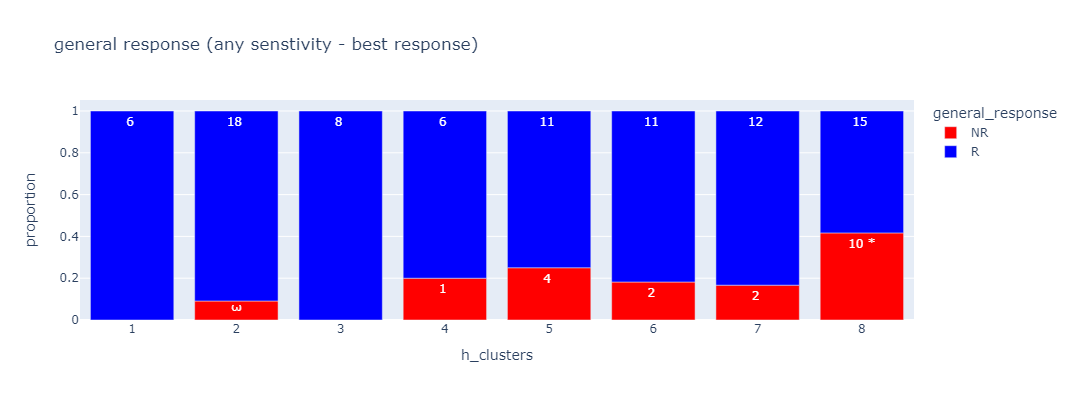

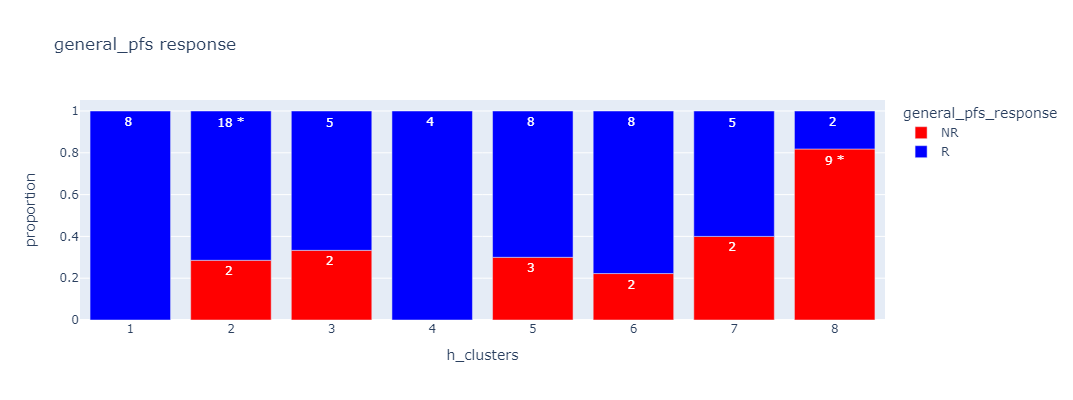

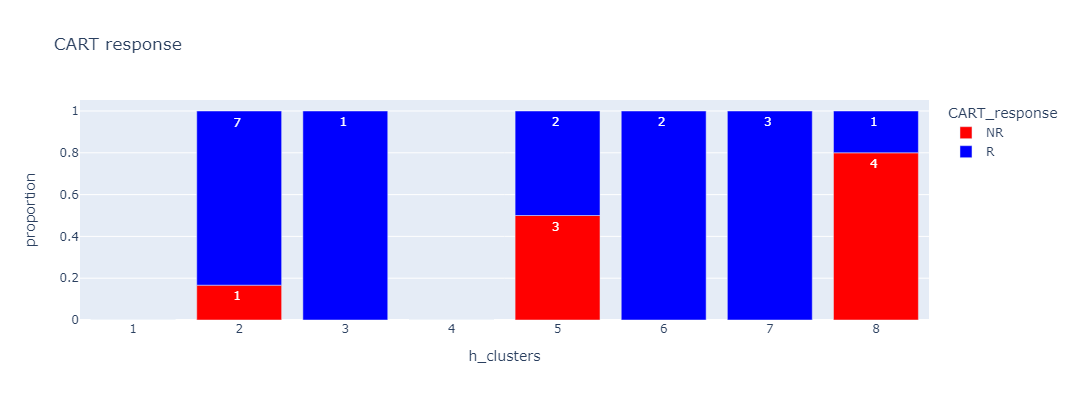

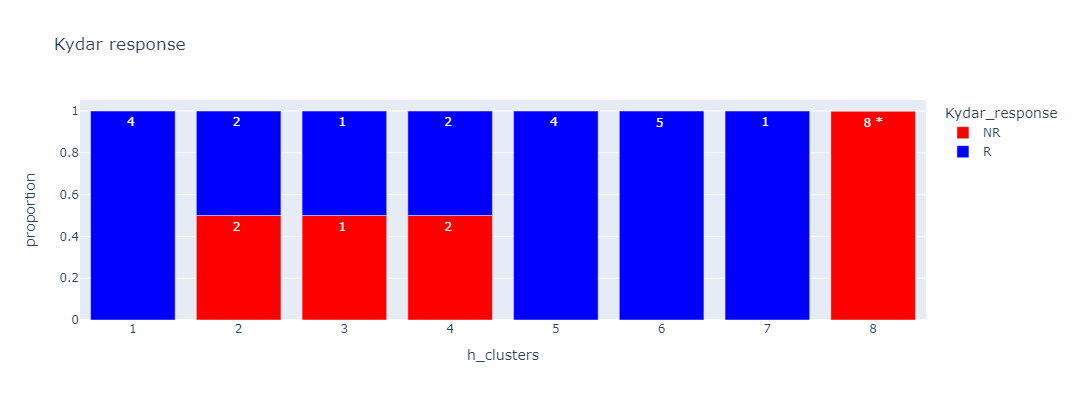

In [360]:
# proportion_data_frame = pateints_df_to_show[pateints_df_to_show['Disease']=="RRMM"]
proportion_data_frame = pateints_df_to_show

box_cols = enrichment_col # 

for treat in ['general', 'general_pfs', "CART", "Kydar"]:
    normalized_df = proportion_data_frame.groupby([box_cols, f"{treat}_response"])["Hospital.Code"].count().reset_index()
    normalized_df = normalized_df.rename(columns={"Hospital.Code": 'count'})
    normalized_df = normalized_df.merge(pateints_df_to_show[pateints_df_to_show['Disease']=="RRMM"].groupby(box_cols)[f"{treat}_response"].value_counts(normalize=True).reset_index(), 
                                        how='inner', on=[box_cols ,f"{treat}_response"])
    
    pvals = []
    for _, row in normalized_df.iterrows():
        if row[f"{treat}_response"] == 'R':
            pval = proba_higher_or_equel_df[treat][row[box_cols]]
        else:
            pval = proba_lower_or_equel_df[treat][row[box_cols]]
        pvals.append(pval)
    normalized_df['pval - enriched'] = pvals
    
    normalized_df['text'] = normalized_df.apply(lambda row: f"{row['count']}", axis=1)
    normalized_df['text'] = normalized_df.apply(lambda row: f"{row['text']} {'*' if row['pval - enriched'] <0.05 else ''}", axis=1)
    

    title = f'{treat} response'
    if treat == "general":
        title += " (any senstivity - best response)"
    f = px.bar(normalized_df,
               title=title,
               x=box_cols, color=f"{treat}_response", y='proportion',
               color_discrete_map={'NR':'red', 'R':'blue'}, text='text', hover_data=['pval - enriched'])
    f.update_xaxes(categoryorder='category ascending')
    f.update_layout(autosize=False, width=600, height=400)
    f.show()

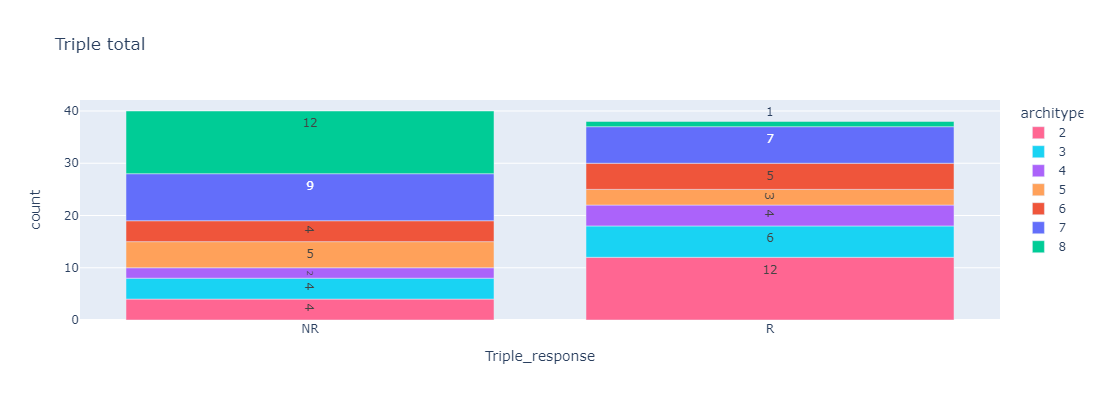

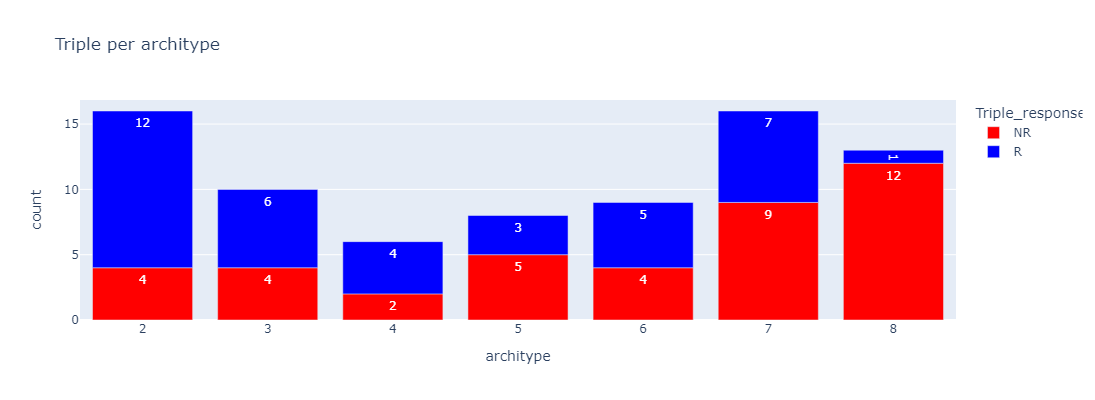

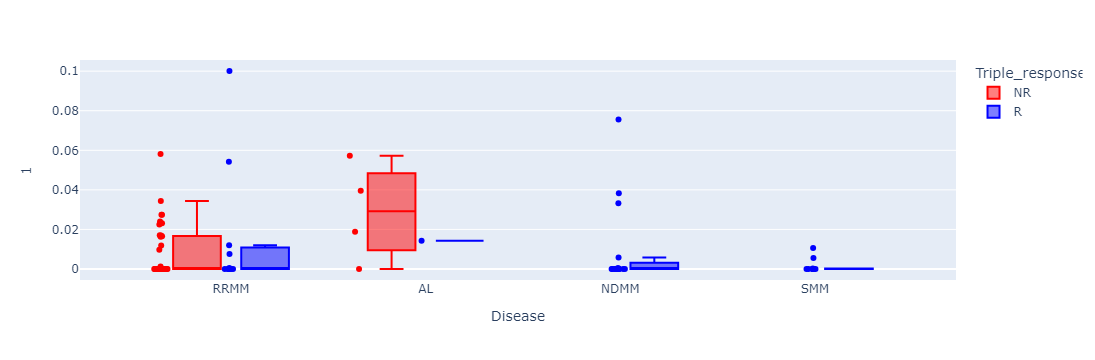

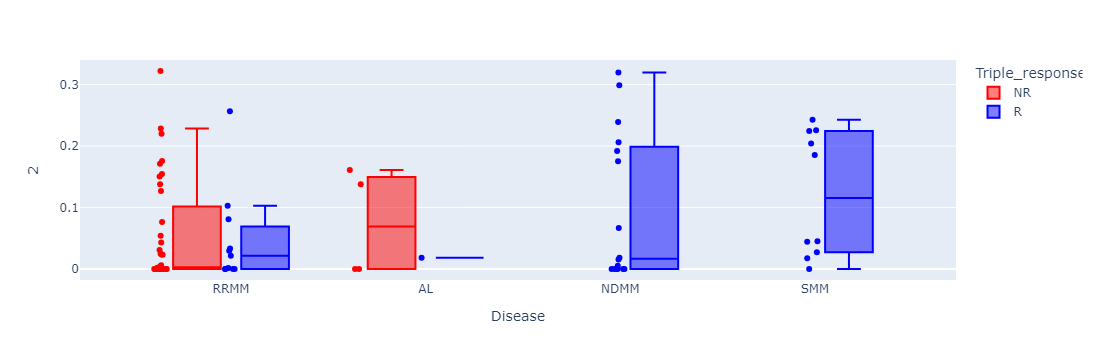

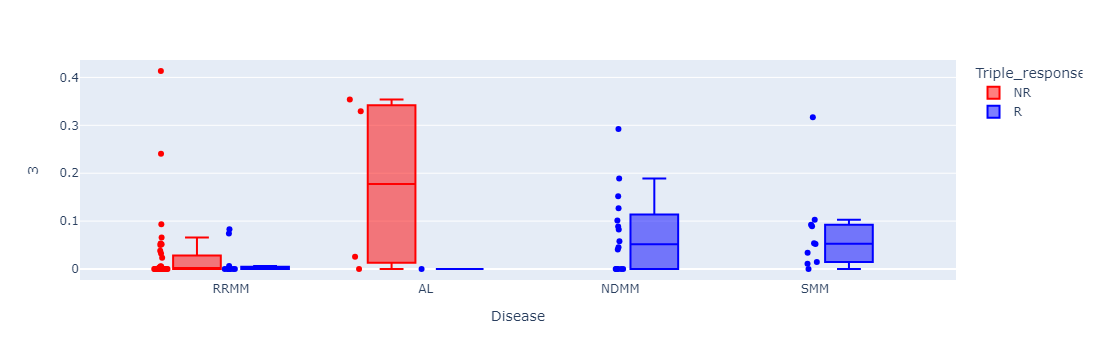

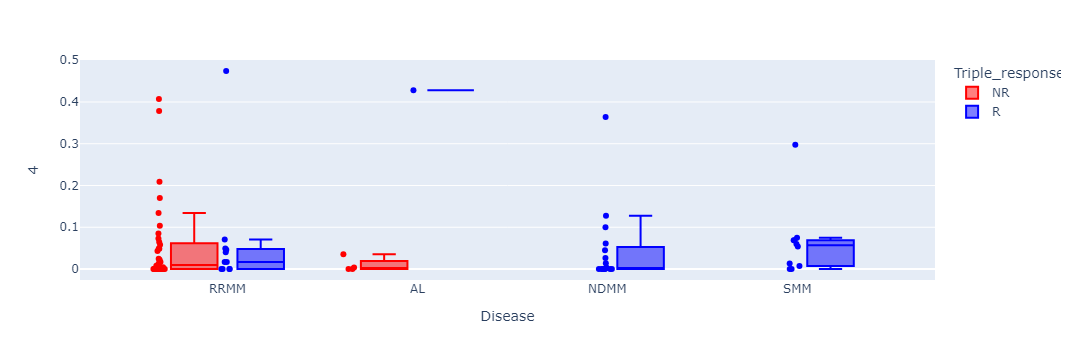

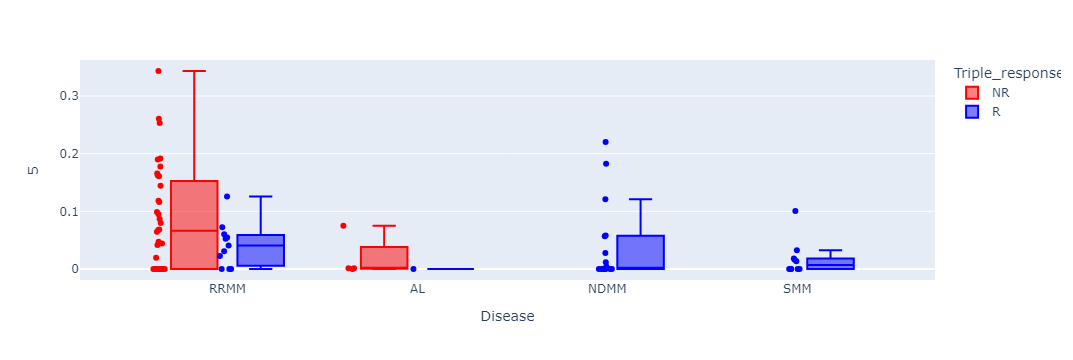

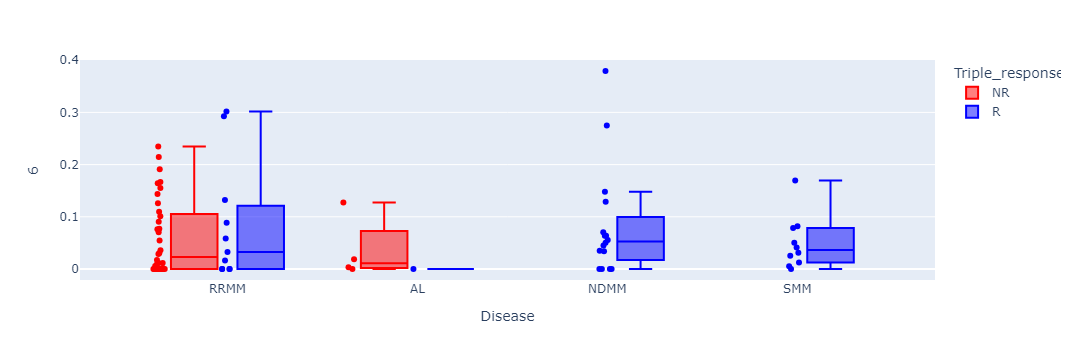

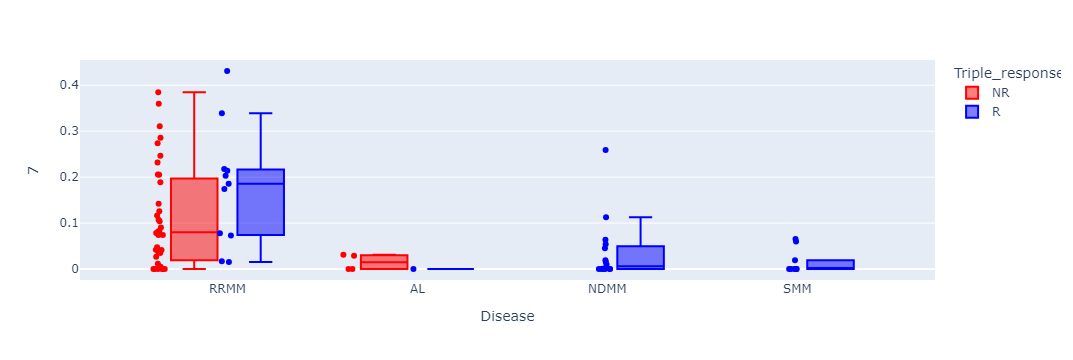

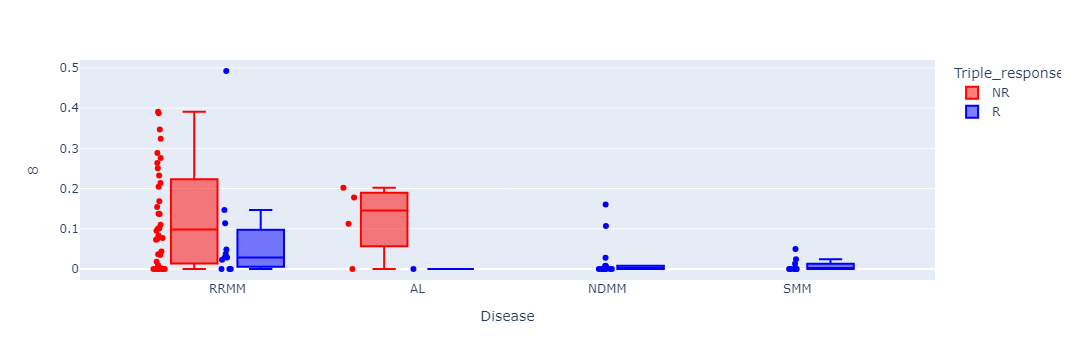

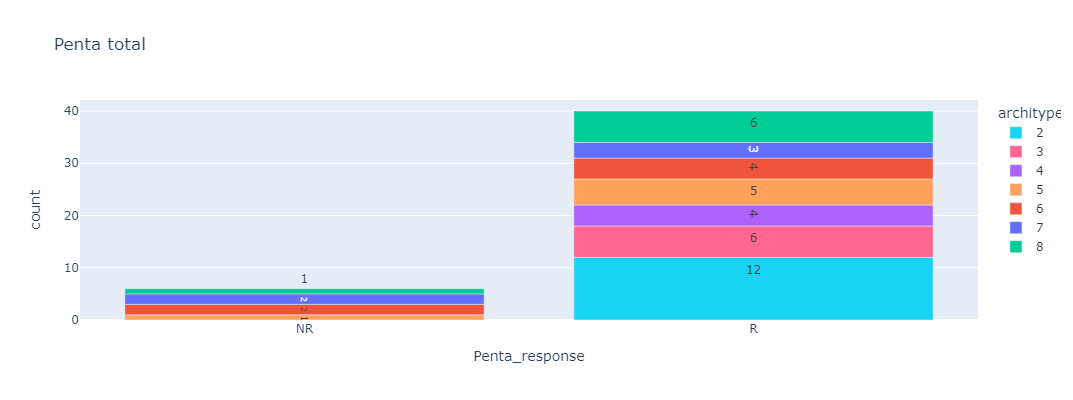

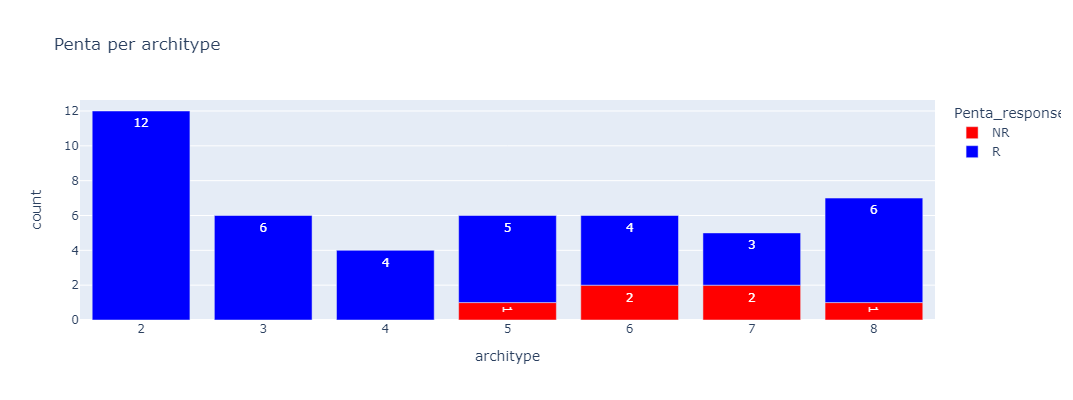

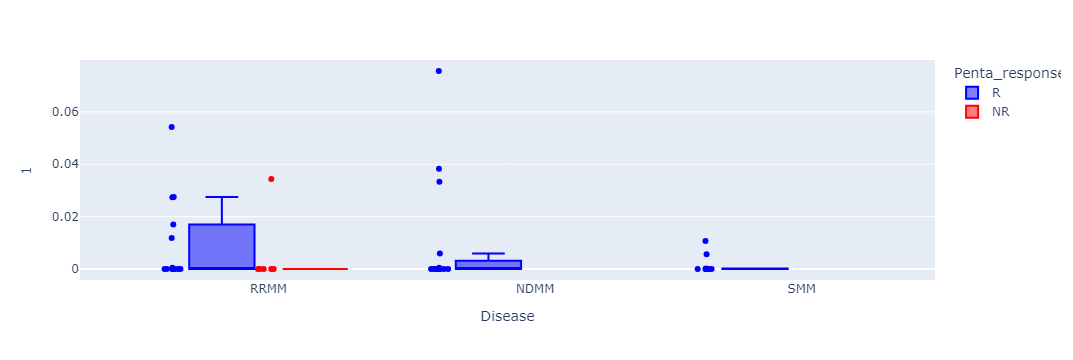

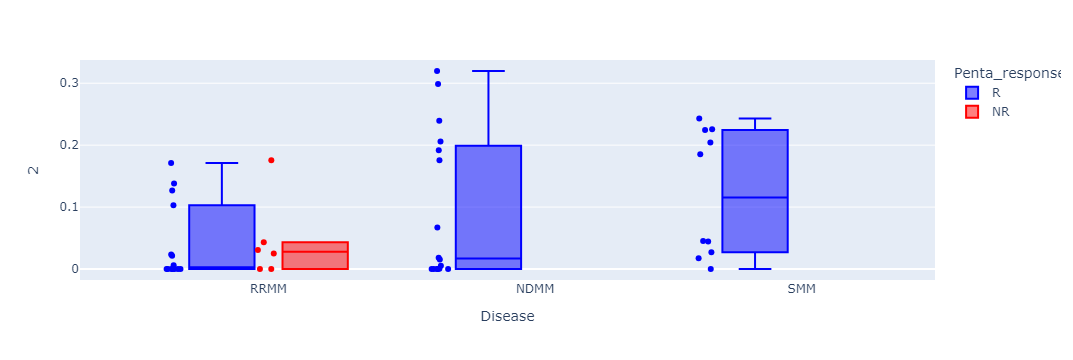

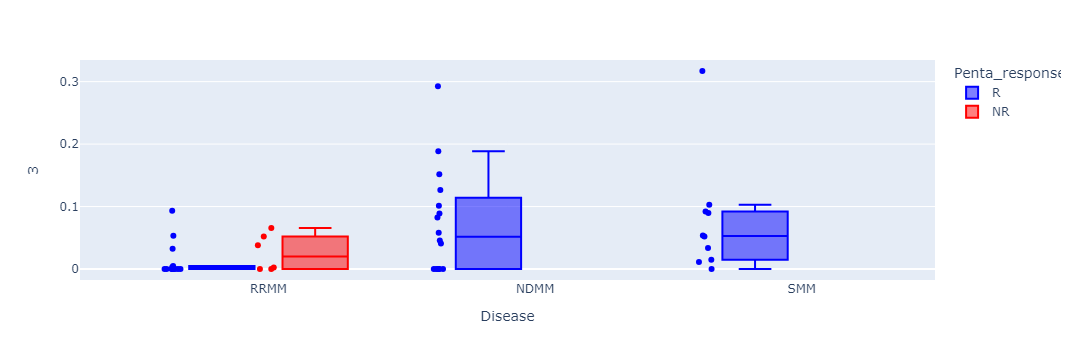

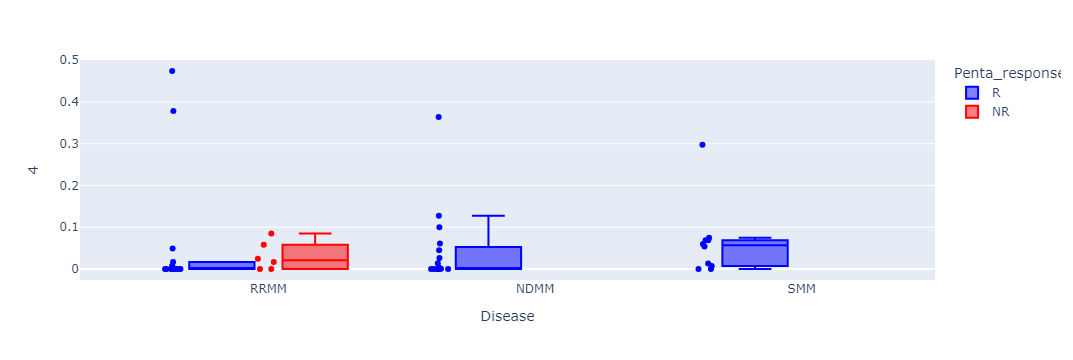

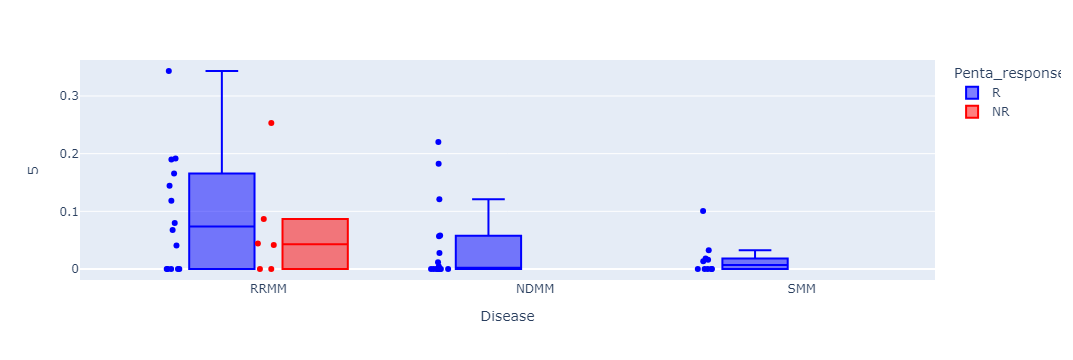

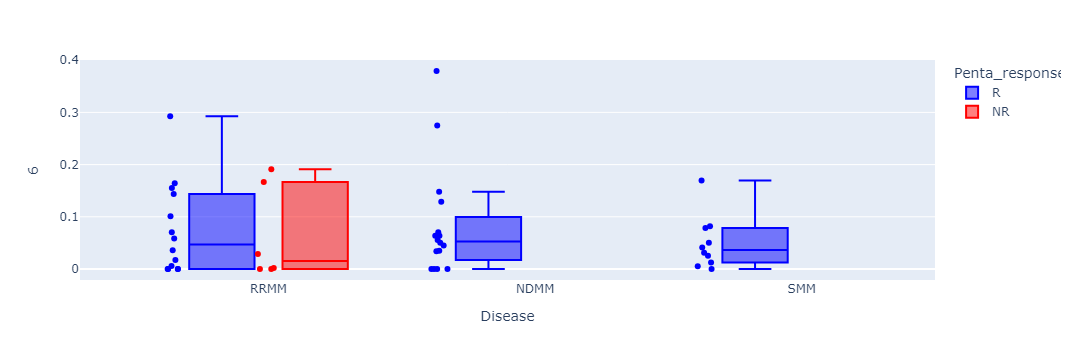

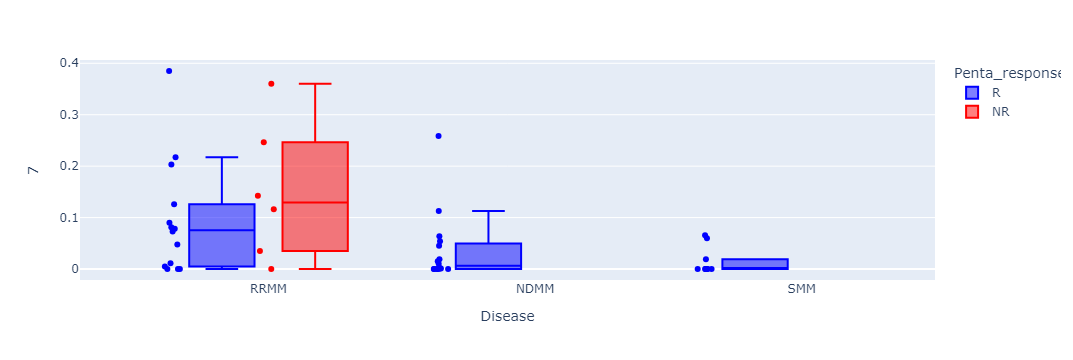

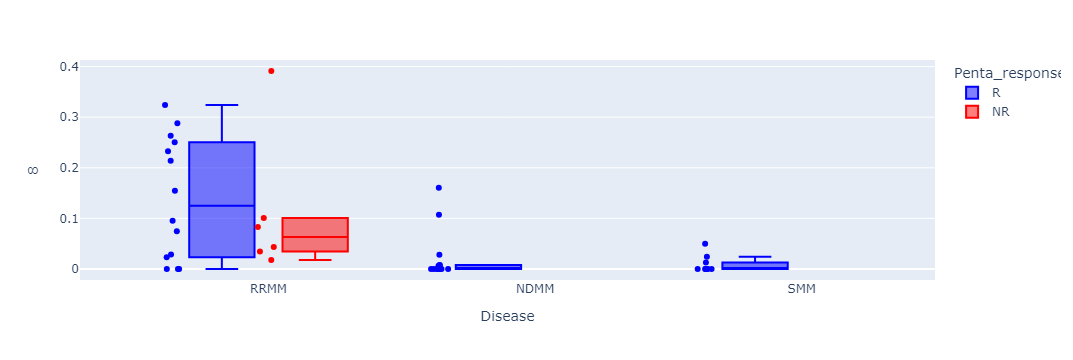

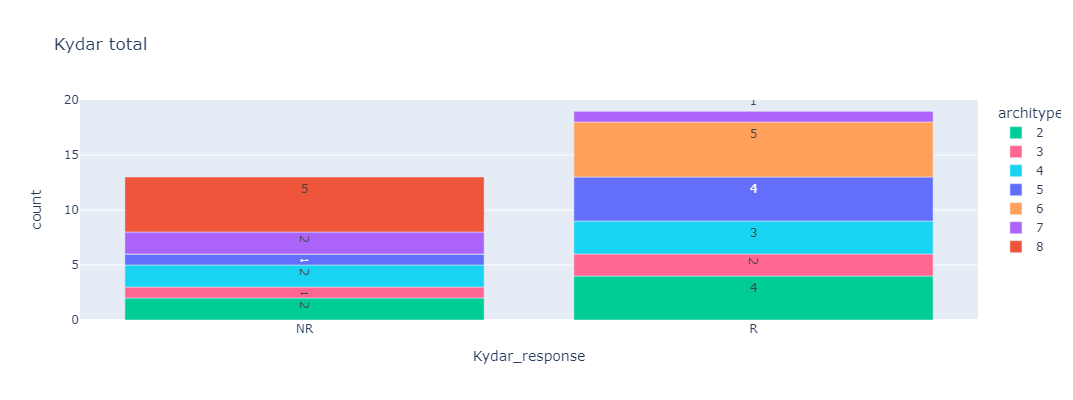

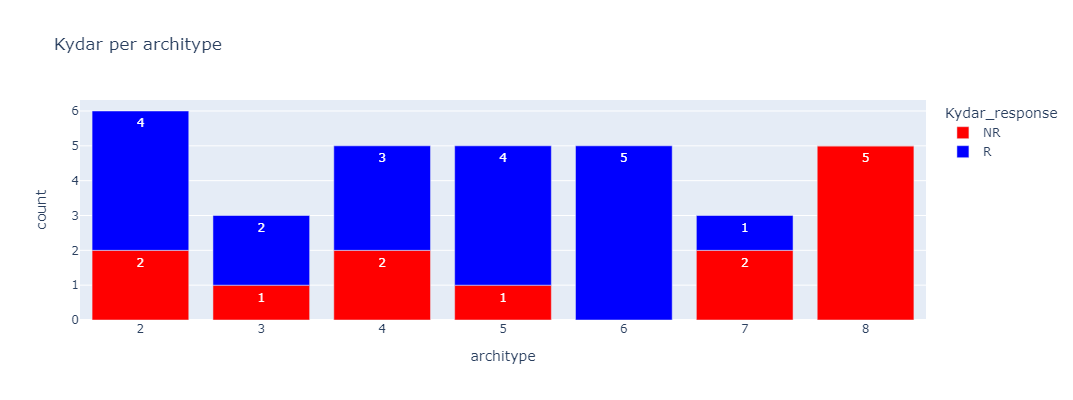

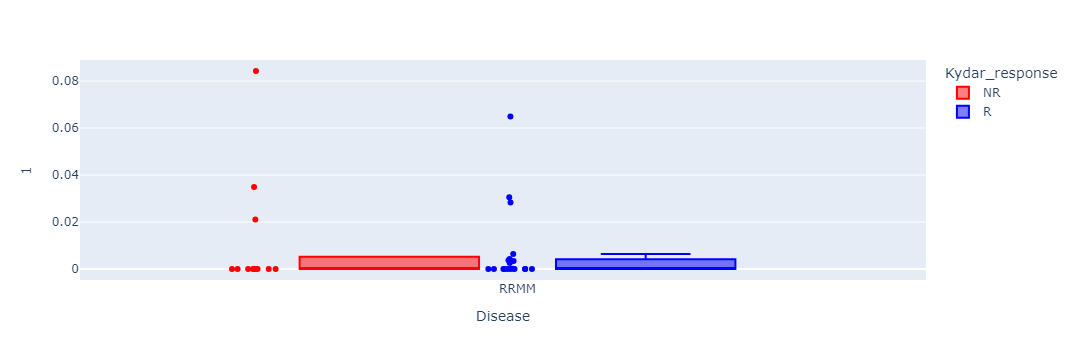

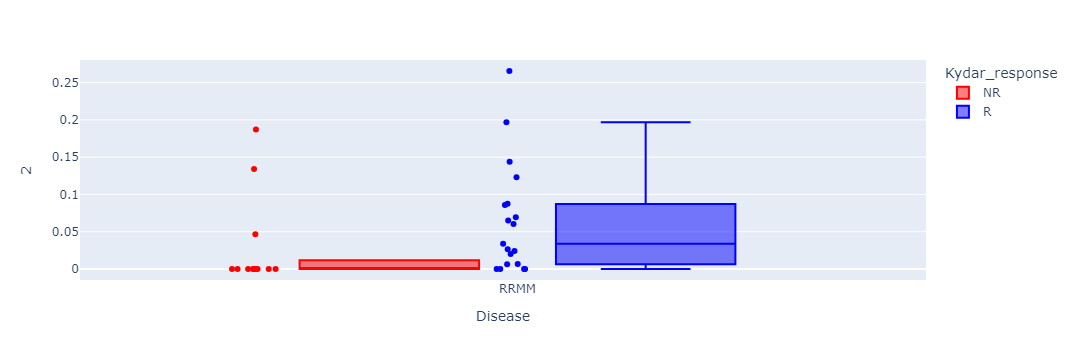

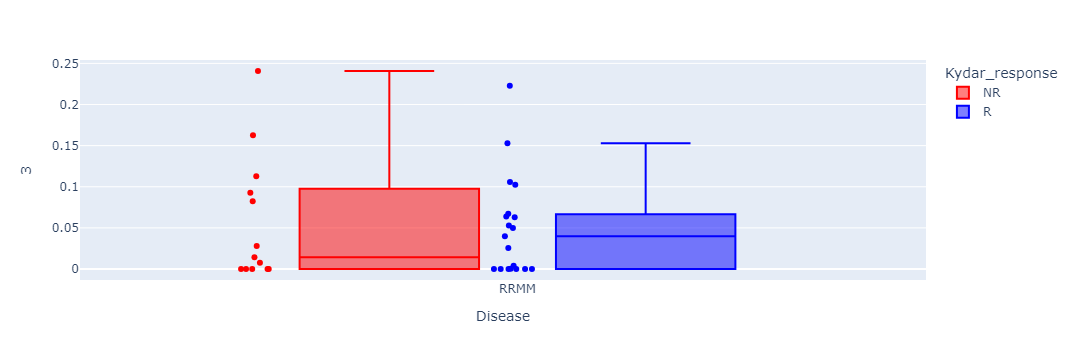

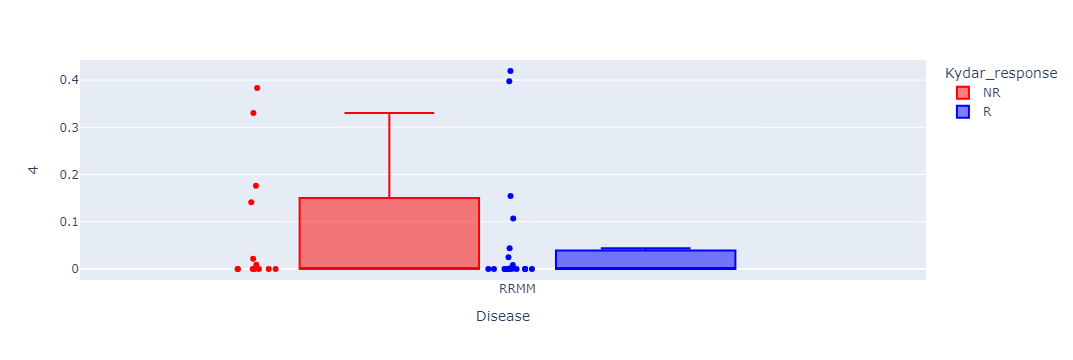

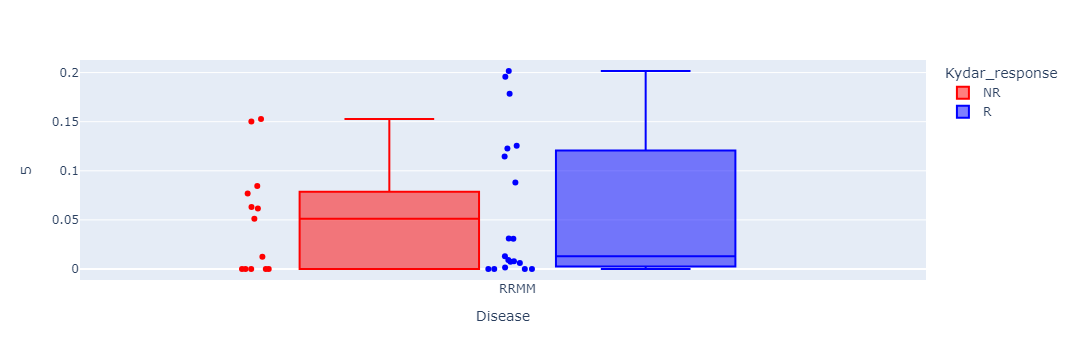

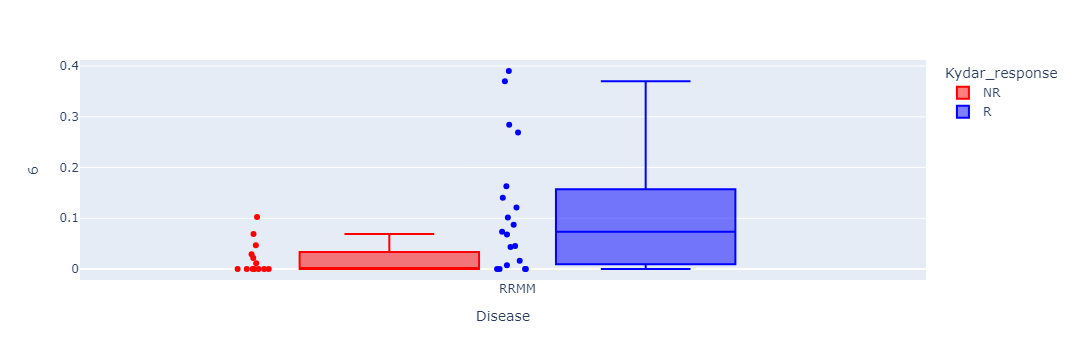

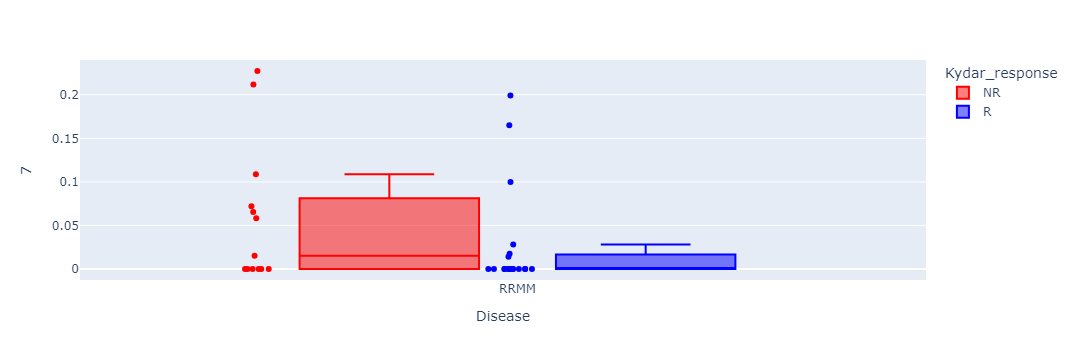

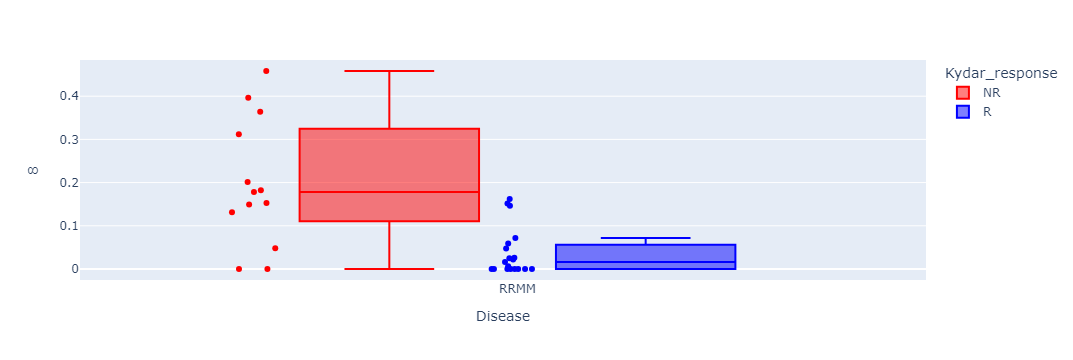

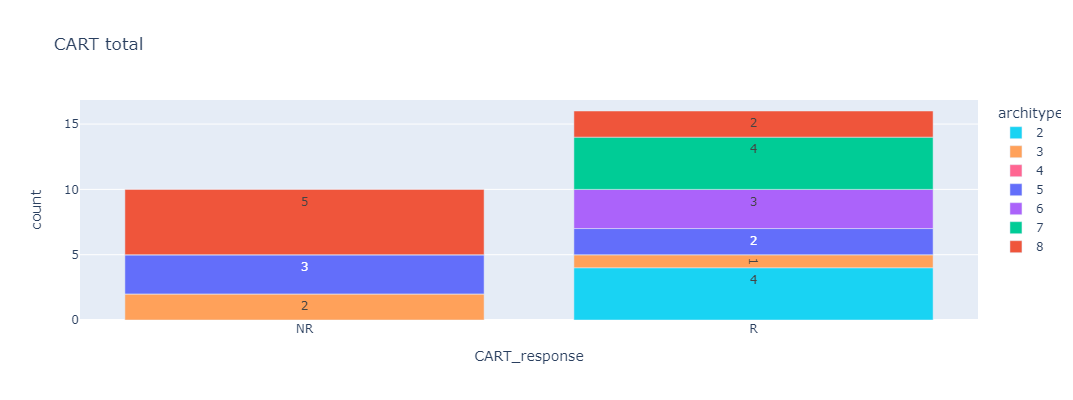

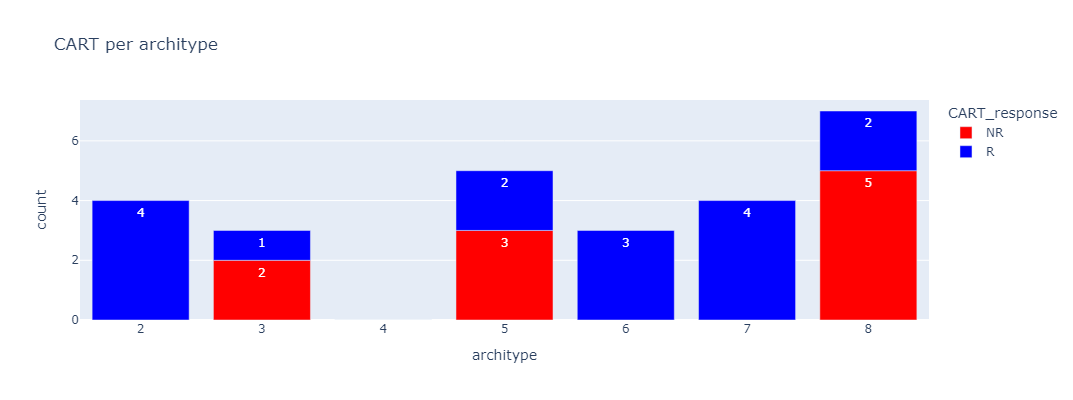

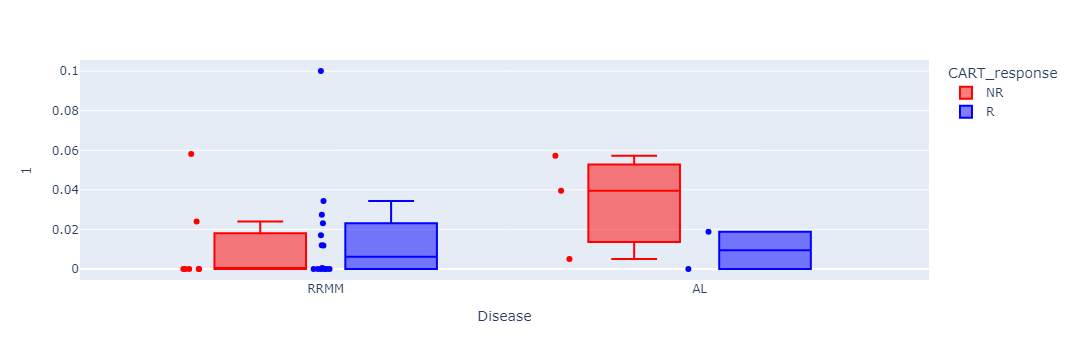

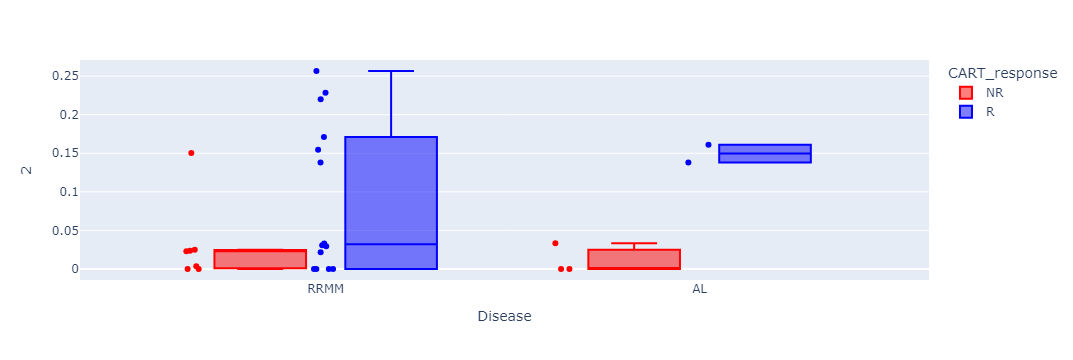

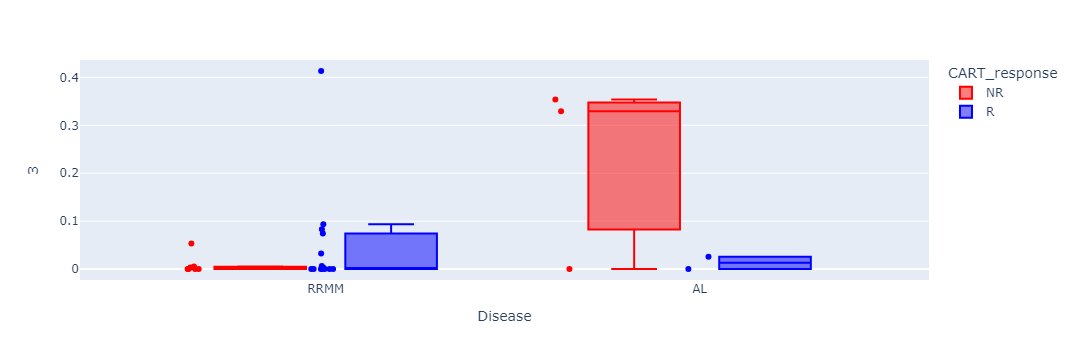

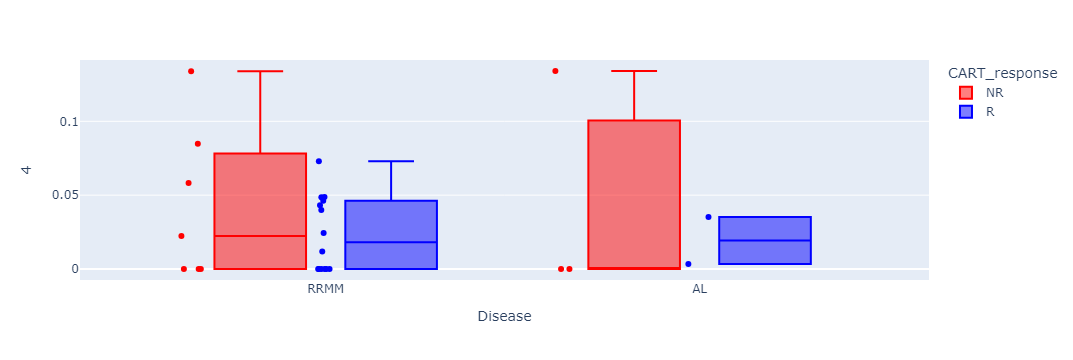

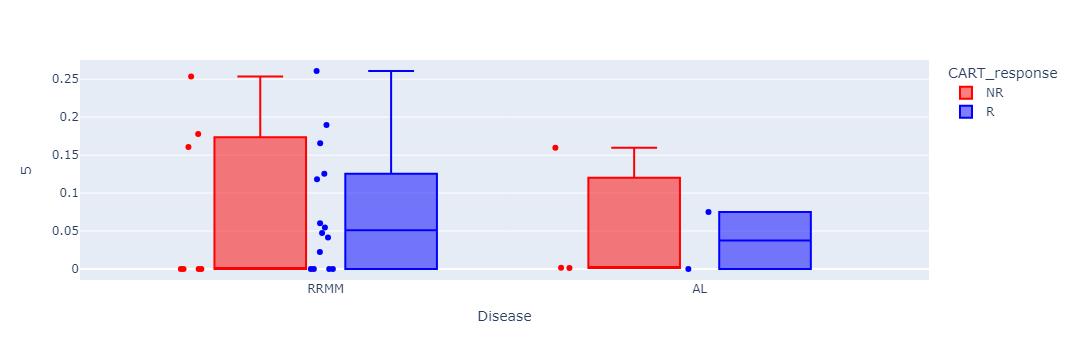

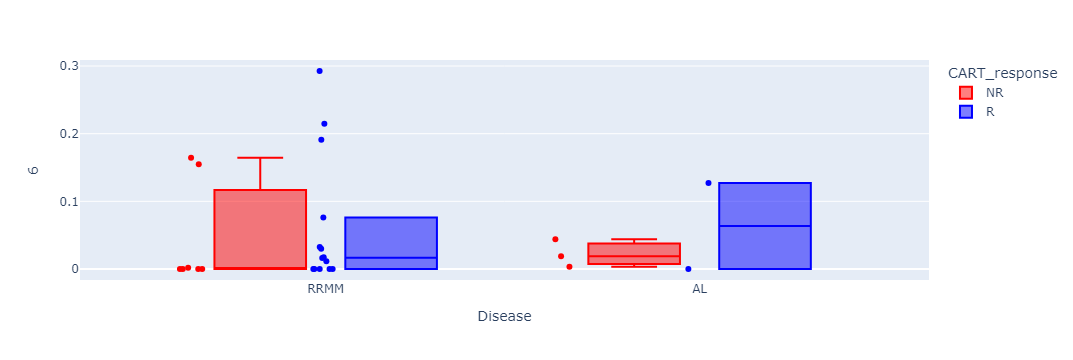

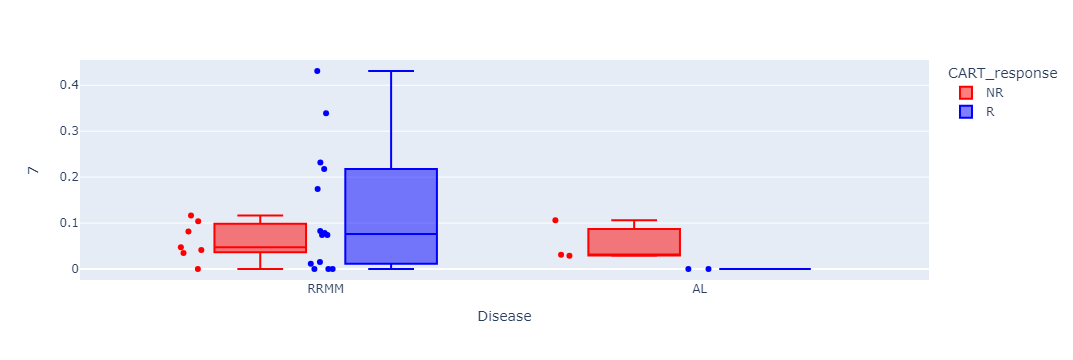

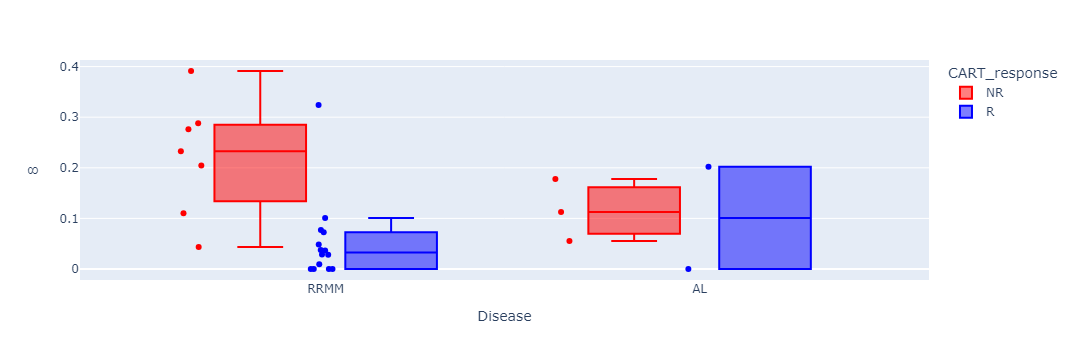

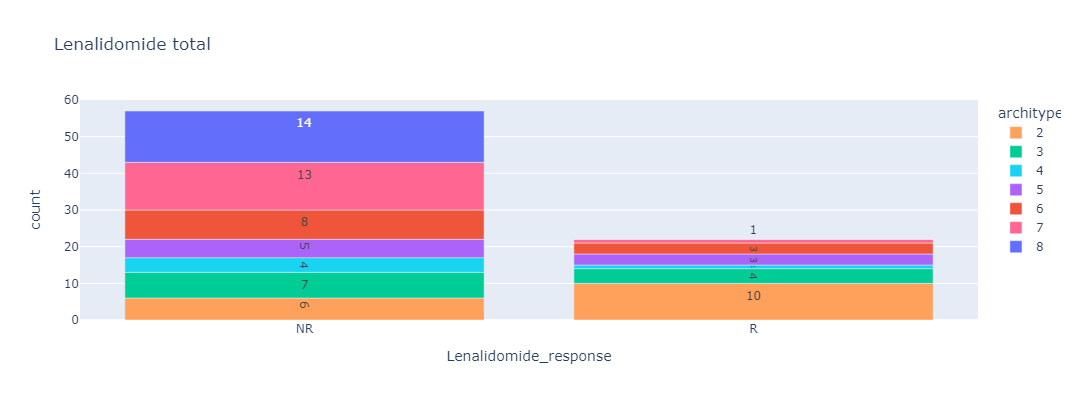

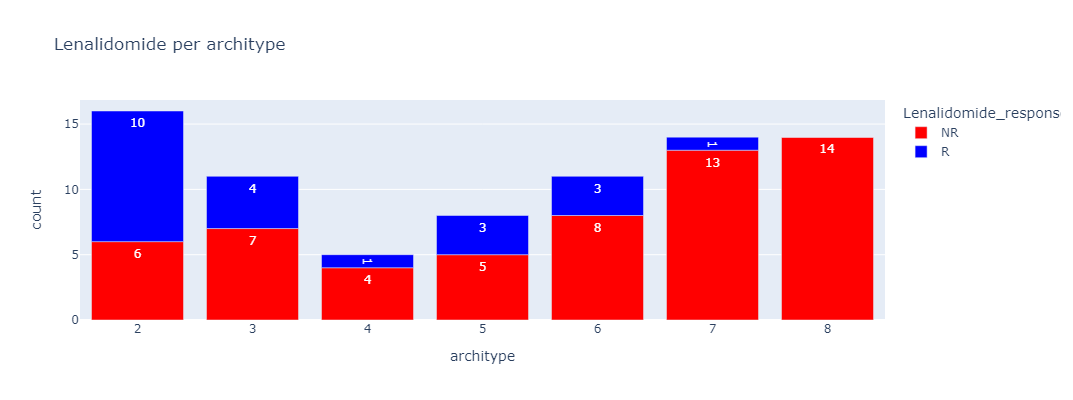

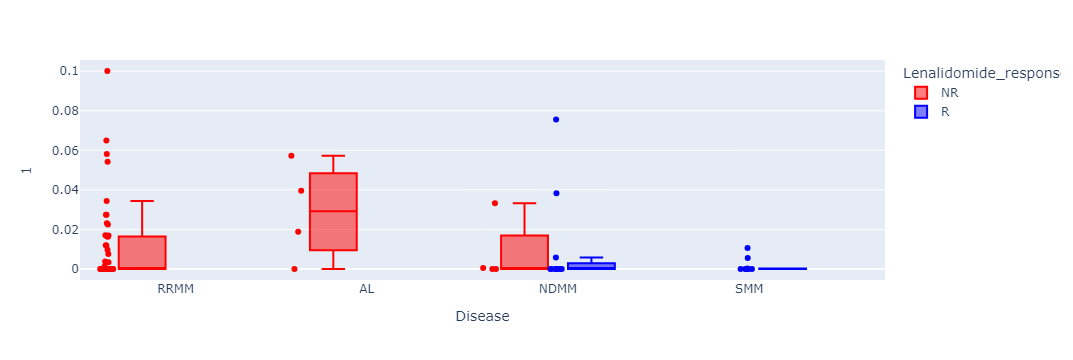

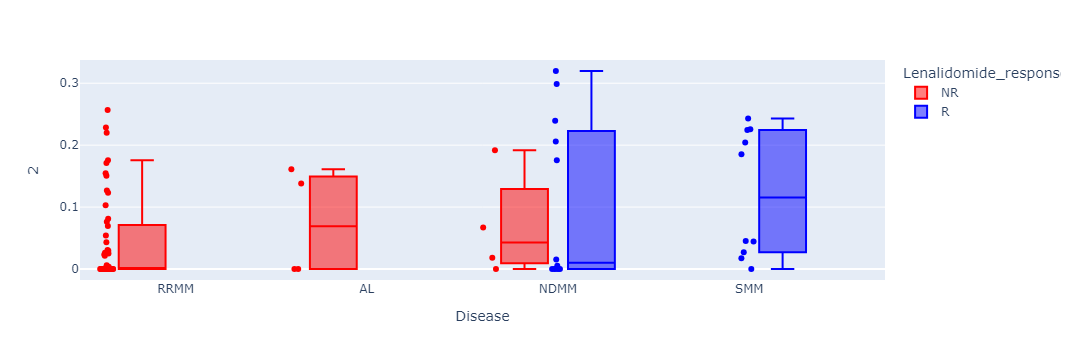

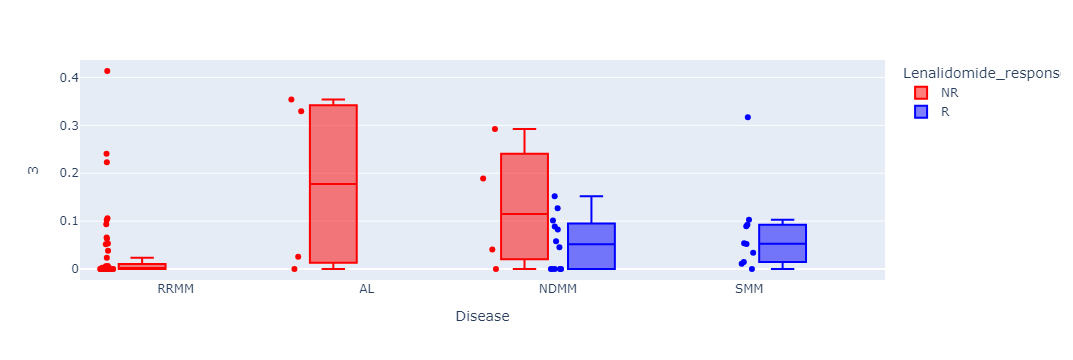

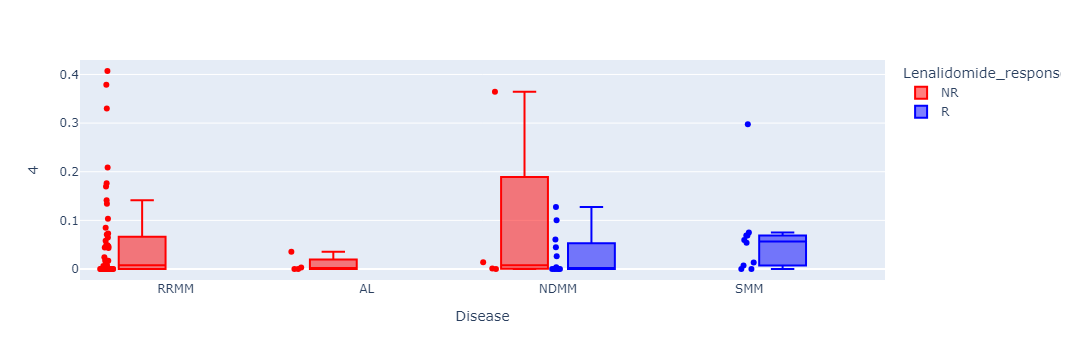

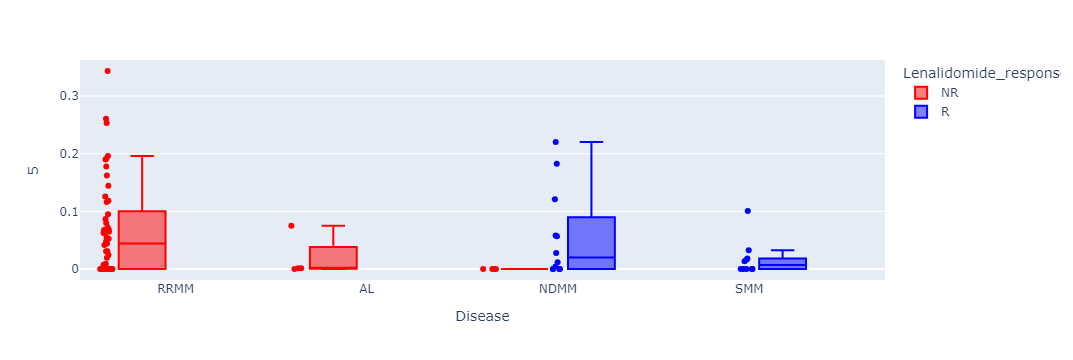

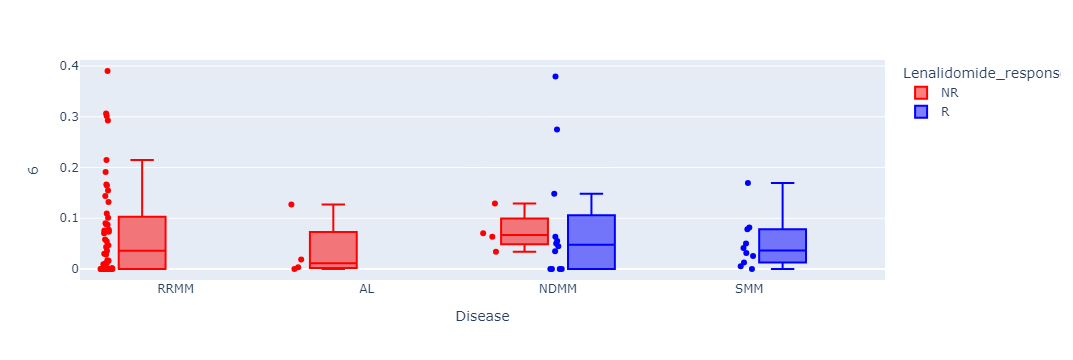

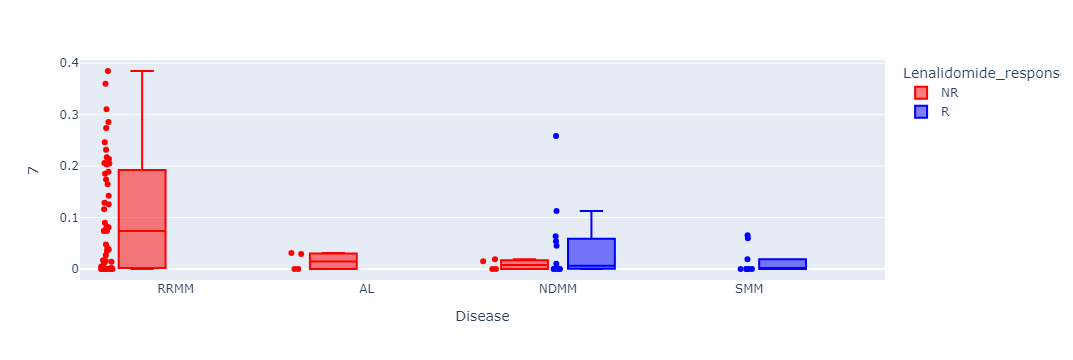

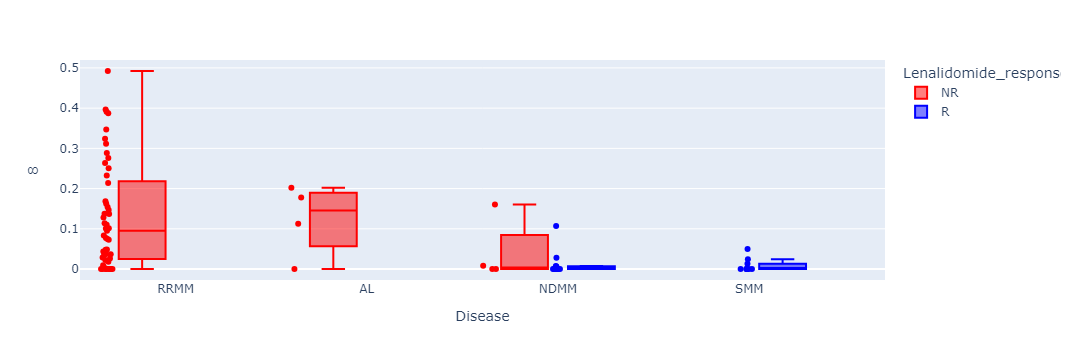

In [361]:
all_figures = []
for treatment in params_df.columns:
    response_col = f"{treatment}_response"
    response_df = pateints_df_mal[[architype_col, response_col]]
    response_df = response_df[~response_df[response_col].isna()]
    grouped_response = response_df.reset_index().rename(columns={"index": "count"}).groupby([architype_col, response_col]).count()
    grouped_response = grouped_response.reset_index()
    grouped_response
    
    figures = []
    
    R_color_map = {"R":"blue", "NR":"red"}
    architypes = response_df[architype_col].unique()
    arch_color_map = dict(zip(architypes, px.colors.qualitative.Plotly))
    
    f_per_arch = px.bar(grouped_response, x=response_col, y="count", color=architype_col,
                          color_discrete_map=arch_color_map, text_auto=True,
                          title=f"{treatment} total", height=400, width=600)
    # f_per_response.update_xaxes(categoryorder='category ascending')    
    figures.append(f_per_arch)
    
    f_per_response = px.bar(grouped_response, x=architype_col, y="count", color=response_col, title=f"{treatment} per architype",
                          color_discrete_map=R_color_map, text_auto=True,
                          height=400, width=600)
    # f_per_response.update_xaxes(categoryorder='category ascending')      
    figures.append(f_per_response)

    for arch in [str(i) for i in range(1,9)]:
        f = px.box(pateints_df_mal,
                   x='Disease', y=arch , color=response_col, 
                   points="all", hover_data=['Hospital.Code'], color_discrete_map={'NR':'red', 'R':'blue'}
                   # title=f"{'proportion' if norm_counts else 'count'} of {cell_population_to_plot} in samples"
                  )
        figures.append(f)
    
    # fig = make_subplots(rows=1, cols=len(figures), subplot_titles=[treatment for f in figures]) 
    
    for i, figure in enumerate(figures):
        figure.show()
        all_figures.append(figure)

In [362]:
# works without the box plots in previus cell

# n_cols = 2
# n_rows = len(all_figures)//2
# titles = [f['layout']['title']['text'] for f in all_figures]
# fig = make_subplots(n_rows, cols=n_cols, subplot_titles=titles) 

# for i, figure in enumerate(all_figures):
#     row = i//2
#     col = i%2
#     if n_cols==1:
#         if col==1:
#             col = 0
#             for trace in range(len(figure["data"])):
#                 fig.add_trace(figure["data"][trace], row=row+1, col=col+1) 
#     else:
#         for trace in range(len(figure["data"])):
#             fig.add_trace(figure["data"][trace], row=row+1, col=col+1) 

# fig.update_layout(height=600, width=800, showlegend=False)
# # fig.update_layout(height=650, width=600)
# # fig.update_xaxes(categoryorder='category ascending')    
# fig.show()